In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns # 引入 seaborn 来使用更专业的调色板
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

# 设置字体为Arial
plt.rcParams['font.family'] = 'Arial'

# 读取可行性分析结果数据
data_path = Path("../result/island_viability_summary_electric.csv")
df = pd.read_csv(data_path)

# 显示数据概况
print(f"数据形状: {df.shape}")
print(f"情景列表: {df['scenario'].unique()}")
print(f"Viability gap统计:")
print(df['viability_gap'].describe())

数据形状: (10980, 16)
情景列表: ['output_0' 'output_2020' 'output_2050' 'output_future_2030'
 'output_future_2040' 'output_future_2050']
Viability gap统计:
count    10980.000000
mean        -0.425257
std          0.739480
min         -4.148942
25%         -1.006200
50%          0.043717
75%          0.082420
max          0.954005
Name: viability_gap, dtype: float64


成功分配IPCC区域，共有 43 个区域
有效区域 (岛屿数量>10): 39 个
有效区域列表: ['SEA', 'EAS', 'NEU', 'MED', 'EPO', 'SAS', 'SPO', 'CAR', 'ENA', 'WAF', 'NAU', 'NAO', 'SWS', 'NWN', 'WNA', 'ARP', 'SCA', 'NPO', 'NZ', 'BOB', 'SSA', 'RFE', 'MDG', 'NCA', 'SAH', 'SAU', 'WCA', 'WCE', 'SEAF', 'NEN', 'ESAF', 'EIO', 'NES', 'EAU', 'SIO', 'GIC', 'CAF', 'EAO', 'NSA']
开始创建三情景云雨图...
ipcc_region列存在，共有 43 个区域
Ideal数据: 1826 个岛屿
2020数据: 1826 个岛屿
2050数据: 1826 个岛屿
2020显著变化岛屿数: 54
2050显著变化岛屿数: 66
发现在至少一个scenario中有显著变化的区域: 13 个
区域列表: ['ENA', 'WNA', 'NWN', 'NEU', 'RFE', 'SAU', 'SSA', 'NZ', 'EAS', 'BOB', 'SWS', 'NPO', 'NAU']
开始生成三情景云雨图...
区域 ENA: Ideal数据 45 个, 2020数据 45 个, 2050数据 45 个
区域 WNA: Ideal数据 18 个, 2020数据 18 个, 2050数据 18 个
区域 NWN: Ideal数据 25 个, 2020数据 25 个, 2050数据 25 个
区域 NEU: Ideal数据 154 个, 2020数据 154 个, 2050数据 154 个
区域 RFE: Ideal数据 10 个, 2020数据 10 个, 2050数据 10 个
区域 SAU: Ideal数据 8 个, 2020数据 8 个, 2050数据 8 个
区域 SSA: Ideal数据 10 个, 2020数据 10 个, 2050数据 10 个
区域 NZ: Ideal数据 11 个, 2020数据 11 个, 2050数据 11 个
区域 EAS: Ideal数据 167 个, 2020数据 167 个

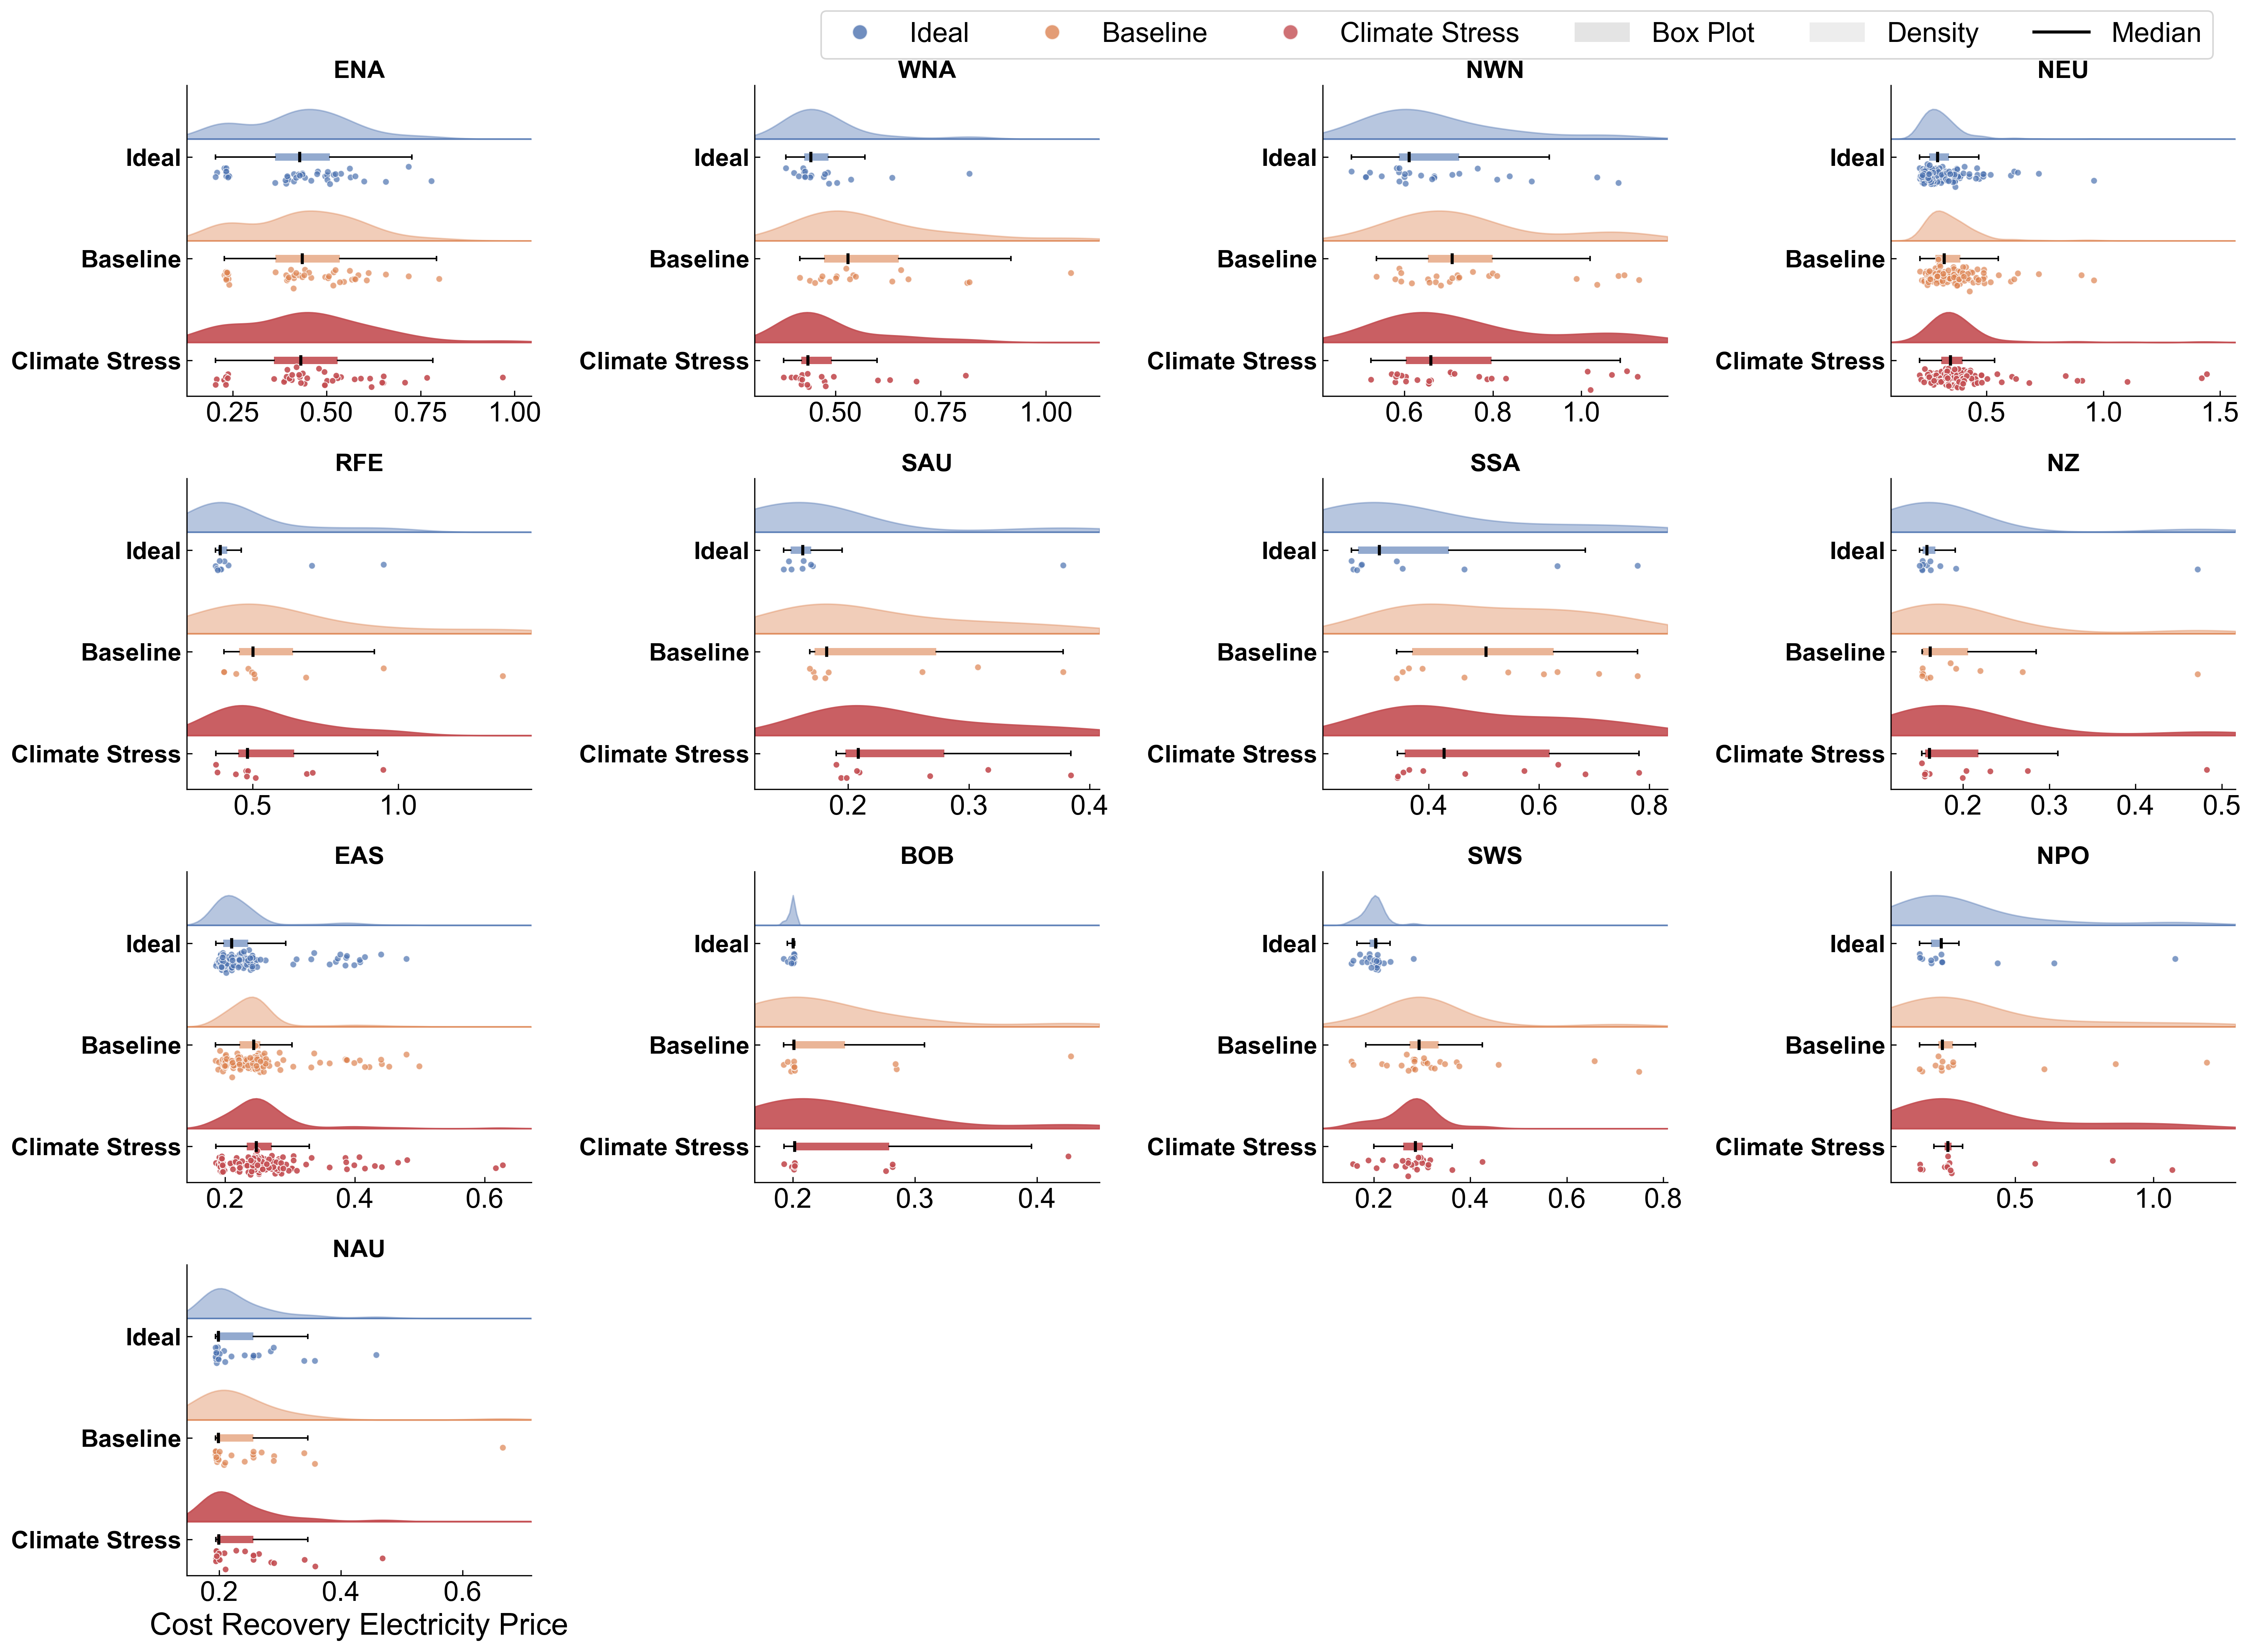


=== 三情景区域tariff_breakeven统计 ===

ENA:
  Ideal: 45 islands, median = 0.428, mean = 0.425
  2020: 45 islands, median = 0.436, mean = 0.436
  2050: 45 islands, median = 0.431, mean = 0.445

WNA:
  Ideal: 18 islands, median = 0.441, mean = 0.478
  2020: 18 islands, median = 0.529, mean = 0.585
  2050: 18 islands, median = 0.435, mean = 0.489

NWN:
  Ideal: 25 islands, median = 0.611, mean = 0.673
  2020: 25 islands, median = 0.708, mean = 0.756
  2050: 25 islands, median = 0.659, mean = 0.741

NEU:
  Ideal: 154 islands, median = 0.289, mean = 0.313
  2020: 154 islands, median = 0.319, mean = 0.349
  2050: 154 islands, median = 0.346, mean = 0.382

RFE:
  Ideal: 10 islands, median = 0.390, mean = 0.477
  2020: 10 islands, median = 0.502, mean = 0.624
  2050: 10 islands, median = 0.482, mean = 0.549

SAU:
  Ideal: 8 islands, median = 0.163, mean = 0.187
  2020: 8 islands, median = 0.182, mean = 0.228
  2050: 8 islands, median = 0.208, mean = 0.246

SSA:
  Ideal: 10 islands, median = 0.311, 

In [95]:
# --- 数据处理函数 ---
def assign_ipcc_region(lat, lon, ipcc_regions_gdf):
    """将岛屿坐标分配到IPCC区域"""
    point = Point(lon, lat)
    possible_matches_index = list(ipcc_regions_gdf.sindex.intersection(point.bounds))
    possible_matches = ipcc_regions_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.contains(point)]
    if not precise_matches.empty:
        return precise_matches.iloc[0]['Acronym']
    return 'Unknown'

def calculate_position_change(df_base, df_compare):
    """计算两个情景之间的位置变化 - 修正版，包含IPCC区域信息"""
    # 修正：合并时包含ipcc_region信息
    merged = pd.merge(df_base[['island_id', 'tariff_breakeven', 'ipcc_region']],
                      df_compare[['island_id', 'tariff_breakeven']],
                      on='island_id', suffixes=('_base', '_compare'))
    merged['position_change'] = abs(merged['tariff_breakeven_compare'] - merged['tariff_breakeven_base'])
    # 重命名ipcc_region列以保持一致性
    merged = merged.rename(columns={'ipcc_region': 'ipcc_region_base'})
    return merged

# --- 1. 数据加载和预处理 ---
try:
    ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")
    ipcc_regions.sindex  # 创建空间索引
    df['ipcc_region'] = df.apply(lambda row: assign_ipcc_region(row['lat'], row['lon'], ipcc_regions), axis=1)
    print(f"成功分配IPCC区域，共有 {df['ipcc_region'].nunique()} 个区域")
except Exception as e:
    print(f"无法加载 geojson 文件或处理数据: {e}.")
    df['ipcc_region'] = 'Unknown'

# 筛选出有效区域（岛屿数量足够的区域）
MIN_ISLANDS_PER_REGION = 10  # 每个区域最少岛屿数量阈值
region_counts = df['ipcc_region'].value_counts()
valid_regions = region_counts[region_counts > MIN_ISLANDS_PER_REGION].index.tolist()
print(f"有效区域 (岛屿数量>{MIN_ISLANDS_PER_REGION}): {len(valid_regions)} 个")
print(f"有效区域列表: {valid_regions}")

def create_raincloud_plot(data_ideal, data_2020, data_2050, ax, region_name, color_ideal, color_2020, color_2050):
    """
    创建改进的云雨图：每个scenario占据上中下三个区域，每个区域内从下到上是点-箱线图-半小提琴图
    x轴显示tariff_breakeven的原始数值，而不是变化量
    
    Args:
        data_ideal: Ideal情景的tariff_breakeven数值
        data_2020: 2020情景的tariff_breakeven数值
        data_2050: 2050情景的tariff_breakeven数值
        ax: matplotlib轴对象
        region_name: IPCC区域名称
        color_ideal, color_2020, color_2050: 三个情景的颜色
    """
    # 计算数据范围
    all_data = np.concatenate([data_ideal, data_2020, data_2050])
    if len(all_data) == 0:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{region_name}', fontsize=10, pad=10, fontweight='bold')
        return
        
    x_min, x_max = all_data.min(), all_data.max()
    x_range = x_max - x_min if x_max != x_min else 1
    x_padding = x_range * 0.1  # x轴边距比例
    
    # 设置y轴位置（分为上中下三个区域）
    # Ideal scenario（上部分：0.68-1.0）
    y_ideal_points = 0.72    # Ideal散点位置
    y_ideal_box = 0.78       # Ideal箱线图位置
    y_ideal_violin = 0.84    # Ideal小提琴图基准线位置
    
    # 2020 scenario（中部分：0.34-0.66）
    y_2020_points = 0.38     # 2020散点位置
    y_2020_box = 0.44        # 2020箱线图位置
    y_2020_violin = 0.50     # 2020小提琴图基准线位置
    
    # 2050 scenario（下部分：0.0-0.32）
    y_2050_points = 0.04     # 2050散点位置
    y_2050_box = 0.10        # 2050箱线图位置
    y_2050_violin = 0.16     # 2050小提琴图基准线位置
    
    np.random.seed(42)  # 确保结果可重现
    
    # === Ideal Scenario（上部分）===
    if len(data_ideal) > 0:
        # 1. 散点图（最下层）
        y_jitter_ideal = np.random.normal(y_ideal_points, 0.015, len(data_ideal))  # 垂直抖动幅度
        ax.scatter(data_ideal, y_jitter_ideal, alpha=0.7, s=18,  # 散点透明度和大小
                  color=color_ideal, edgecolors='white', linewidth=0.5, zorder=3)  # 边框颜色和宽度
        
        # 2. 箱线图（中间层）
        q25, q50, q75 = np.percentile(data_ideal, [25, 50, 75])  # 计算四分位数
        iqr = q75 - q25  # 四分位距
        whisker_low = max(data_ideal.min(), q25 - 1.5 * iqr)  # 下须限制
        whisker_high = min(data_ideal.max(), q75 + 1.5 * iqr)  # 上须限制
        
        # 箱体
        box_height = 0.025  # 箱体高度
        ax.add_patch(plt.Rectangle((q25, y_ideal_box - box_height/2), q75 - q25, box_height,
                                  facecolor=color_ideal, alpha=0.6, zorder=2))  # 箱体透明度
        # 中位数线
        ax.plot([q50, q50], [y_ideal_box - box_height/2, y_ideal_box + box_height/2], 
               color='black', linewidth=2, zorder=4)  # 中位数线宽度
        # 须线
        ax.plot([whisker_low, q25], [y_ideal_box, y_ideal_box], color='black', linewidth=1, zorder=2)  # 须线宽度
        ax.plot([q75, whisker_high], [y_ideal_box, y_ideal_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_ideal_box - box_height/4, y_ideal_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_ideal_box - box_height/4, y_ideal_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        
        # 3. 半小提琴图（上层，只显示向上的部分）
        if len(data_ideal) > 3:
            try:
                kde_ideal = stats.gaussian_kde(data_ideal)  # 核密度估计
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)  # 密度估计x轴范围
                density_ideal = kde_ideal(x_kde)
                # 归一化密度并缩放
                density_ideal_scaled = density_ideal / density_ideal.max() * 0.10  # 小提琴图高度缩放
                
                # 只向上填充（半小提琴）
                ax.fill_between(x_kde, y_ideal_violin, y_ideal_violin + density_ideal_scaled, 
                              alpha=0.4, color=color_ideal, zorder=1)  # 小提琴图透明度
                # 底边线
                ax.plot(x_kde, [y_ideal_violin] * len(x_kde), color=color_ideal, linewidth=1, alpha=0.8, zorder=1)
            except:
                pass
    
    # === 2020 Scenario（中部分）===
    if len(data_2020) > 0:
        # 1. 散点图（最下层）
        y_jitter_2020 = np.random.normal(y_2020_points, 0.015, len(data_2020))
        ax.scatter(data_2020, y_jitter_2020, alpha=0.7, s=18, 
                  color=color_2020, edgecolors='white', linewidth=0.5, zorder=3)
        
        # 2. 箱线图（中间层）
        q25, q50, q75 = np.percentile(data_2020, [25, 50, 75])
        iqr = q75 - q25
        whisker_low = max(data_2020.min(), q25 - 1.5 * iqr)
        whisker_high = min(data_2020.max(), q75 + 1.5 * iqr)
        
        # 箱体
        box_height = 0.025
        ax.add_patch(plt.Rectangle((q25, y_2020_box - box_height/2), q75 - q25, box_height,
                                  facecolor=color_2020, alpha=0.6, zorder=2))
        # 中位数线
        ax.plot([q50, q50], [y_2020_box - box_height/2, y_2020_box + box_height/2], 
               color='black', linewidth=2, zorder=4)
        # 须线
        ax.plot([whisker_low, q25], [y_2020_box, y_2020_box], color='black', linewidth=1, zorder=2)
        ax.plot([q75, whisker_high], [y_2020_box, y_2020_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_2020_box - box_height/4, y_2020_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_2020_box - box_height/4, y_2020_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        
        # 3. 半小提琴图（上层，只显示向上的部分）
        if len(data_2020) > 3:
            try:
                kde_2020 = stats.gaussian_kde(data_2020)
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)
                density_2020 = kde_2020(x_kde)
                # 归一化密度并缩放
                density_2020_scaled = density_2020 / density_2020.max() * 0.10
                
                # 只向上填充（半小提琴）
                ax.fill_between(x_kde, y_2020_violin, y_2020_violin + density_2020_scaled, 
                              alpha=0.4, color=color_2020, zorder=1)
                # 底边线
                ax.plot(x_kde, [y_2020_violin] * len(x_kde), color=color_2020, linewidth=1, alpha=0.8, zorder=1)
            except:
                pass
    
    # === 2050 Scenario（下部分）===
    if len(data_2050) > 0:
        # 1. 散点图（最下层）
        y_jitter_2050 = np.random.normal(y_2050_points, 0.015, len(data_2050))
        ax.scatter(data_2050, y_jitter_2050, alpha=0.9, s=18, 
                  color=color_2050, edgecolors='white', linewidth=0.5, zorder=3)
        
        # 2. 箱线图（中间层）
        q25, q50, q75 = np.percentile(data_2050, [25, 50, 75])
        iqr = q75 - q25
        whisker_low = max(data_2050.min(), q25 - 1.5 * iqr)
        whisker_high = min(data_2050.max(), q75 + 1.5 * iqr)
        
        # 箱体
        box_height = 0.025
        ax.add_patch(plt.Rectangle((q25, y_2050_box - box_height/2), q75 - q25, box_height,
                                  facecolor=color_2050, alpha=0.9, zorder=2))
        # 中位数线
        ax.plot([q50, q50], [y_2050_box - box_height/2, y_2050_box + box_height/2], 
               color='black', linewidth=2, zorder=4)
        # 须线
        ax.plot([whisker_low, q25], [y_2050_box, y_2050_box], color='black', linewidth=1, zorder=2)
        ax.plot([q75, whisker_high], [y_2050_box, y_2050_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_2050_box - box_height/4, y_2050_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_2050_box - box_height/4, y_2050_box + box_height/4], 
               color='black', linewidth=1, zorder=2)
        
        # 3. 半小提琴图（上层，只显示向上的部分）
        if len(data_2050) > 3:
            try:
                kde_2050 = stats.gaussian_kde(data_2050)
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)
                density_2050 = kde_2050(x_kde)
                # 归一化密度并缩放
                density_2050_scaled = density_2050 / density_2050.max() * 0.10
                
                # 只向上填充（半小提琴）
                ax.fill_between(x_kde, y_2050_violin, y_2050_violin + density_2050_scaled, 
                              alpha=0.9, color=color_2050, zorder=1)
                # 底边线
                ax.plot(x_kde, [y_2050_violin] * len(x_kde), color=color_2050, linewidth=1, alpha=0.8, zorder=1)
            except:
                pass
    
    # 4. 设置轴和标签
    ax.set_ylim(-0.02, 1.02)  # y轴范围
    
    # 设置y轴标签，标识三个scenario区域
    ax.set_yticks([0.10, 0.44, 0.78])  # 在每个scenario的中间位置设置刻度
    ax.set_yticklabels(['Climate Stress', 'Baseline', 'Ideal'], fontsize=16, fontweight='bold')  # y轴标签字体大小和粗细
    
    ax.set_title(f'{region_name}', fontsize=16, pad=5, fontweight='bold')  # 标题字体大小和粗细
    ax.grid(False)  # 关闭网格
    ax.spines['right'].set_visible(False)  # 隐藏右侧边框
    ax.spines['top'].set_visible(False)    # 隐藏顶部边框
    
    # 设置x轴范围
    ax.set_xlim(x_min - x_padding, x_max + x_padding)


# 主程序：创建多子图云雨图
if __name__ == '__main__':
    print("开始创建三情景云雨图...")
    
    # 检查ipcc_region列是否存在
    if 'ipcc_region' not in df.columns:
        print("错误：ipcc_region列不存在！")
    else:
        print(f"ipcc_region列存在，共有 {df['ipcc_region'].nunique()} 个区域")
    
    # 筛选三个情景的数据（基于有显著变化的岛屿）
    df_base_ideal = df[(df['scenario'] == 'output_0') & (df['ipcc_region'].isin(valid_regions))].copy()
    df_compare_2020 = df[(df['scenario'] == 'output_2020') & (df['ipcc_region'].isin(valid_regions))].copy()
    df_compare_2050 = df[(df['scenario'] == 'output_2050') & (df['ipcc_region'].isin(valid_regions))].copy()

    print(f"Ideal数据: {len(df_base_ideal)} 个岛屿")
    print(f"2020数据: {len(df_compare_2020)} 个岛屿")
    print(f"2050数据: {len(df_compare_2050)} 个岛屿")

    # 计算变化以确定哪些岛屿有显著变化（仍然用于筛选）
    change_2020 = calculate_position_change(df_base_ideal, df_compare_2020)
    change_2050 = calculate_position_change(df_base_ideal, df_compare_2050)
    
    # 筛选有显著变化的区域（基于2020和2050的变化）
    significant_2020 = change_2020[change_2020['position_change'] > 0.1]  # 显著性阈值
    significant_2050 = change_2050[change_2050['position_change'] > 0.1]
    
    print(f"2020显著变化岛屿数: {len(significant_2020)}")
    print(f"2050显著变化岛屿数: {len(significant_2050)}")
    
    # 获取在至少一个scenario中有显著变化的区域
    regions_2020 = set(significant_2020['ipcc_region_base'].unique()) if len(significant_2020) > 0 else set()
    regions_2050 = set(significant_2050['ipcc_region_base'].unique()) if len(significant_2050) > 0 else set()
    common_regions = list(regions_2020.union(regions_2050))  # 使用并集，显示所有有变化的区域
    
    print(f"发现在至少一个scenario中有显著变化的区域: {len(common_regions)} 个")
    print(f"区域列表: {common_regions}")
    
    if len(common_regions) == 0:
        print("没有发现有显著变化的区域")
    else:
        print("开始生成三情景云雨图...")
        # 计算子图布局
        n_regions = len(common_regions)
        n_cols = min(4, n_regions)  # 最多4列
        n_rows = (n_regions + n_cols - 1) // n_cols  # 向上取整计算行数
        
        # 创建图形
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.2*n_cols, 4*n_rows), dpi=300)  # 图形大小和分辨率
        if n_regions == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.flatten()
        else:
            axes = axes.flatten()
        
        # 定义三个情景的颜色
        color_ideal = '#4C72B0'   # Ideal情景颜色 - 蓝色
        color_2020 = '#DD8452'    # 2020情景颜色 - 橙色  
        color_2050 = '#C44E52'    # 2050情景颜色 - 红色
        
        # 为每个区域创建子图
        for i, region in enumerate(common_regions):
            ax = axes[i]
            
            # 获取该区域在三个scenario下的tariff_breakeven原始数值（不是变化量）
            region_data_ideal = df_base_ideal[df_base_ideal['ipcc_region'] == region]['tariff_breakeven'].values
            region_data_2020 = df_compare_2020[df_compare_2020['ipcc_region'] == region]['tariff_breakeven'].values
            region_data_2050 = df_compare_2050[df_compare_2050['ipcc_region'] == region]['tariff_breakeven'].values
            
            print(f"区域 {region}: Ideal数据 {len(region_data_ideal)} 个, 2020数据 {len(region_data_2020)} 个, 2050数据 {len(region_data_2050)} 个")
            
            # 绘制改进的三情景云雨图（使用原始数值，不是变化量）
            create_raincloud_plot(region_data_ideal, region_data_2020, region_data_2050, ax, 
                                region, color_ideal, color_2020, color_2050)
        
        # 隐藏多余的子图
        for i in range(n_regions, len(axes)):
            axes[i].set_visible(False)
        
        # 为所有子图添加统一的x轴标签
        for i in range(n_regions):
            if i >= (n_rows-1) * n_cols:  # 最后一行的子图
                axes[i].set_xlabel('Cost Recovery Electricity Price', fontsize=20)  # x轴标签字体大小
        
        # 添加图例
        from matplotlib.lines import Line2D
        from matplotlib.patches import Patch
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color_ideal, 
                  markersize=10, label='Ideal', alpha=0.8),  # Ideal图例
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color_2020, 
                  markersize=10, label='Baseline', alpha=0.8),  # Baseline图例
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color_2050, 
                  markersize=10, label='Climate Stress', alpha=0.8),  # Climate Stress图例
            # Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
            #       markersize=10, label='Scatter Points', alpha=0.7),  # 散点图例
            Patch(facecolor='lightgray', alpha=0.6, label='Box Plot'),  # 箱线图图例
            Patch(facecolor='lightgray', alpha=0.4, label='Density'),  # 密度图图例
            Line2D([0], [0], color='black', linewidth=2, label='Median')  # 中位数线图例
        ]
        fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95), ncol=7, fontsize=18)  # 图例位置和字体大小
        
        plt.tight_layout()  # 自动调整子图间距
        plt.subplots_adjust(top=0.90)  # 调整顶部边距为图例留出空间
        plt.show()
        
        # 打印统计信息
        print(f"\n=== 三情景区域tariff_breakeven统计 ===")
        for region in common_regions:
            data_ideal = df_base_ideal[df_base_ideal['ipcc_region'] == region]['tariff_breakeven'].values
            data_2020 = df_compare_2020[df_compare_2020['ipcc_region'] == region]['tariff_breakeven'].values
            data_2050 = df_compare_2050[df_compare_2050['ipcc_region'] == region]['tariff_breakeven'].values
            
            print(f"\n{region}:")
            if len(data_ideal) > 0:
                print(f"  Ideal: {len(data_ideal)} islands, median = {np.median(data_ideal):.3f}, mean = {np.mean(data_ideal):.3f}")
            if len(data_2020) > 0:
                print(f"  2020: {len(data_2020)} islands, median = {np.median(data_2020):.3f}, mean = {np.mean(data_2020):.3f}")
            if len(data_2050) > 0:
                print(f"  2050: {len(data_2050)} islands, median = {np.median(data_2050):.3f}, mean = {np.mean(data_2050):.3f}")

ipcc_region列已存在，开始分析...

--- 正在对比三个情景，但只显示在 'output_0' 和 'output_2020' 之间有显著变化的岛屿 ---
发现 171 个有显著变化的岛屿（在 output_0 和 output_2020 之间）。


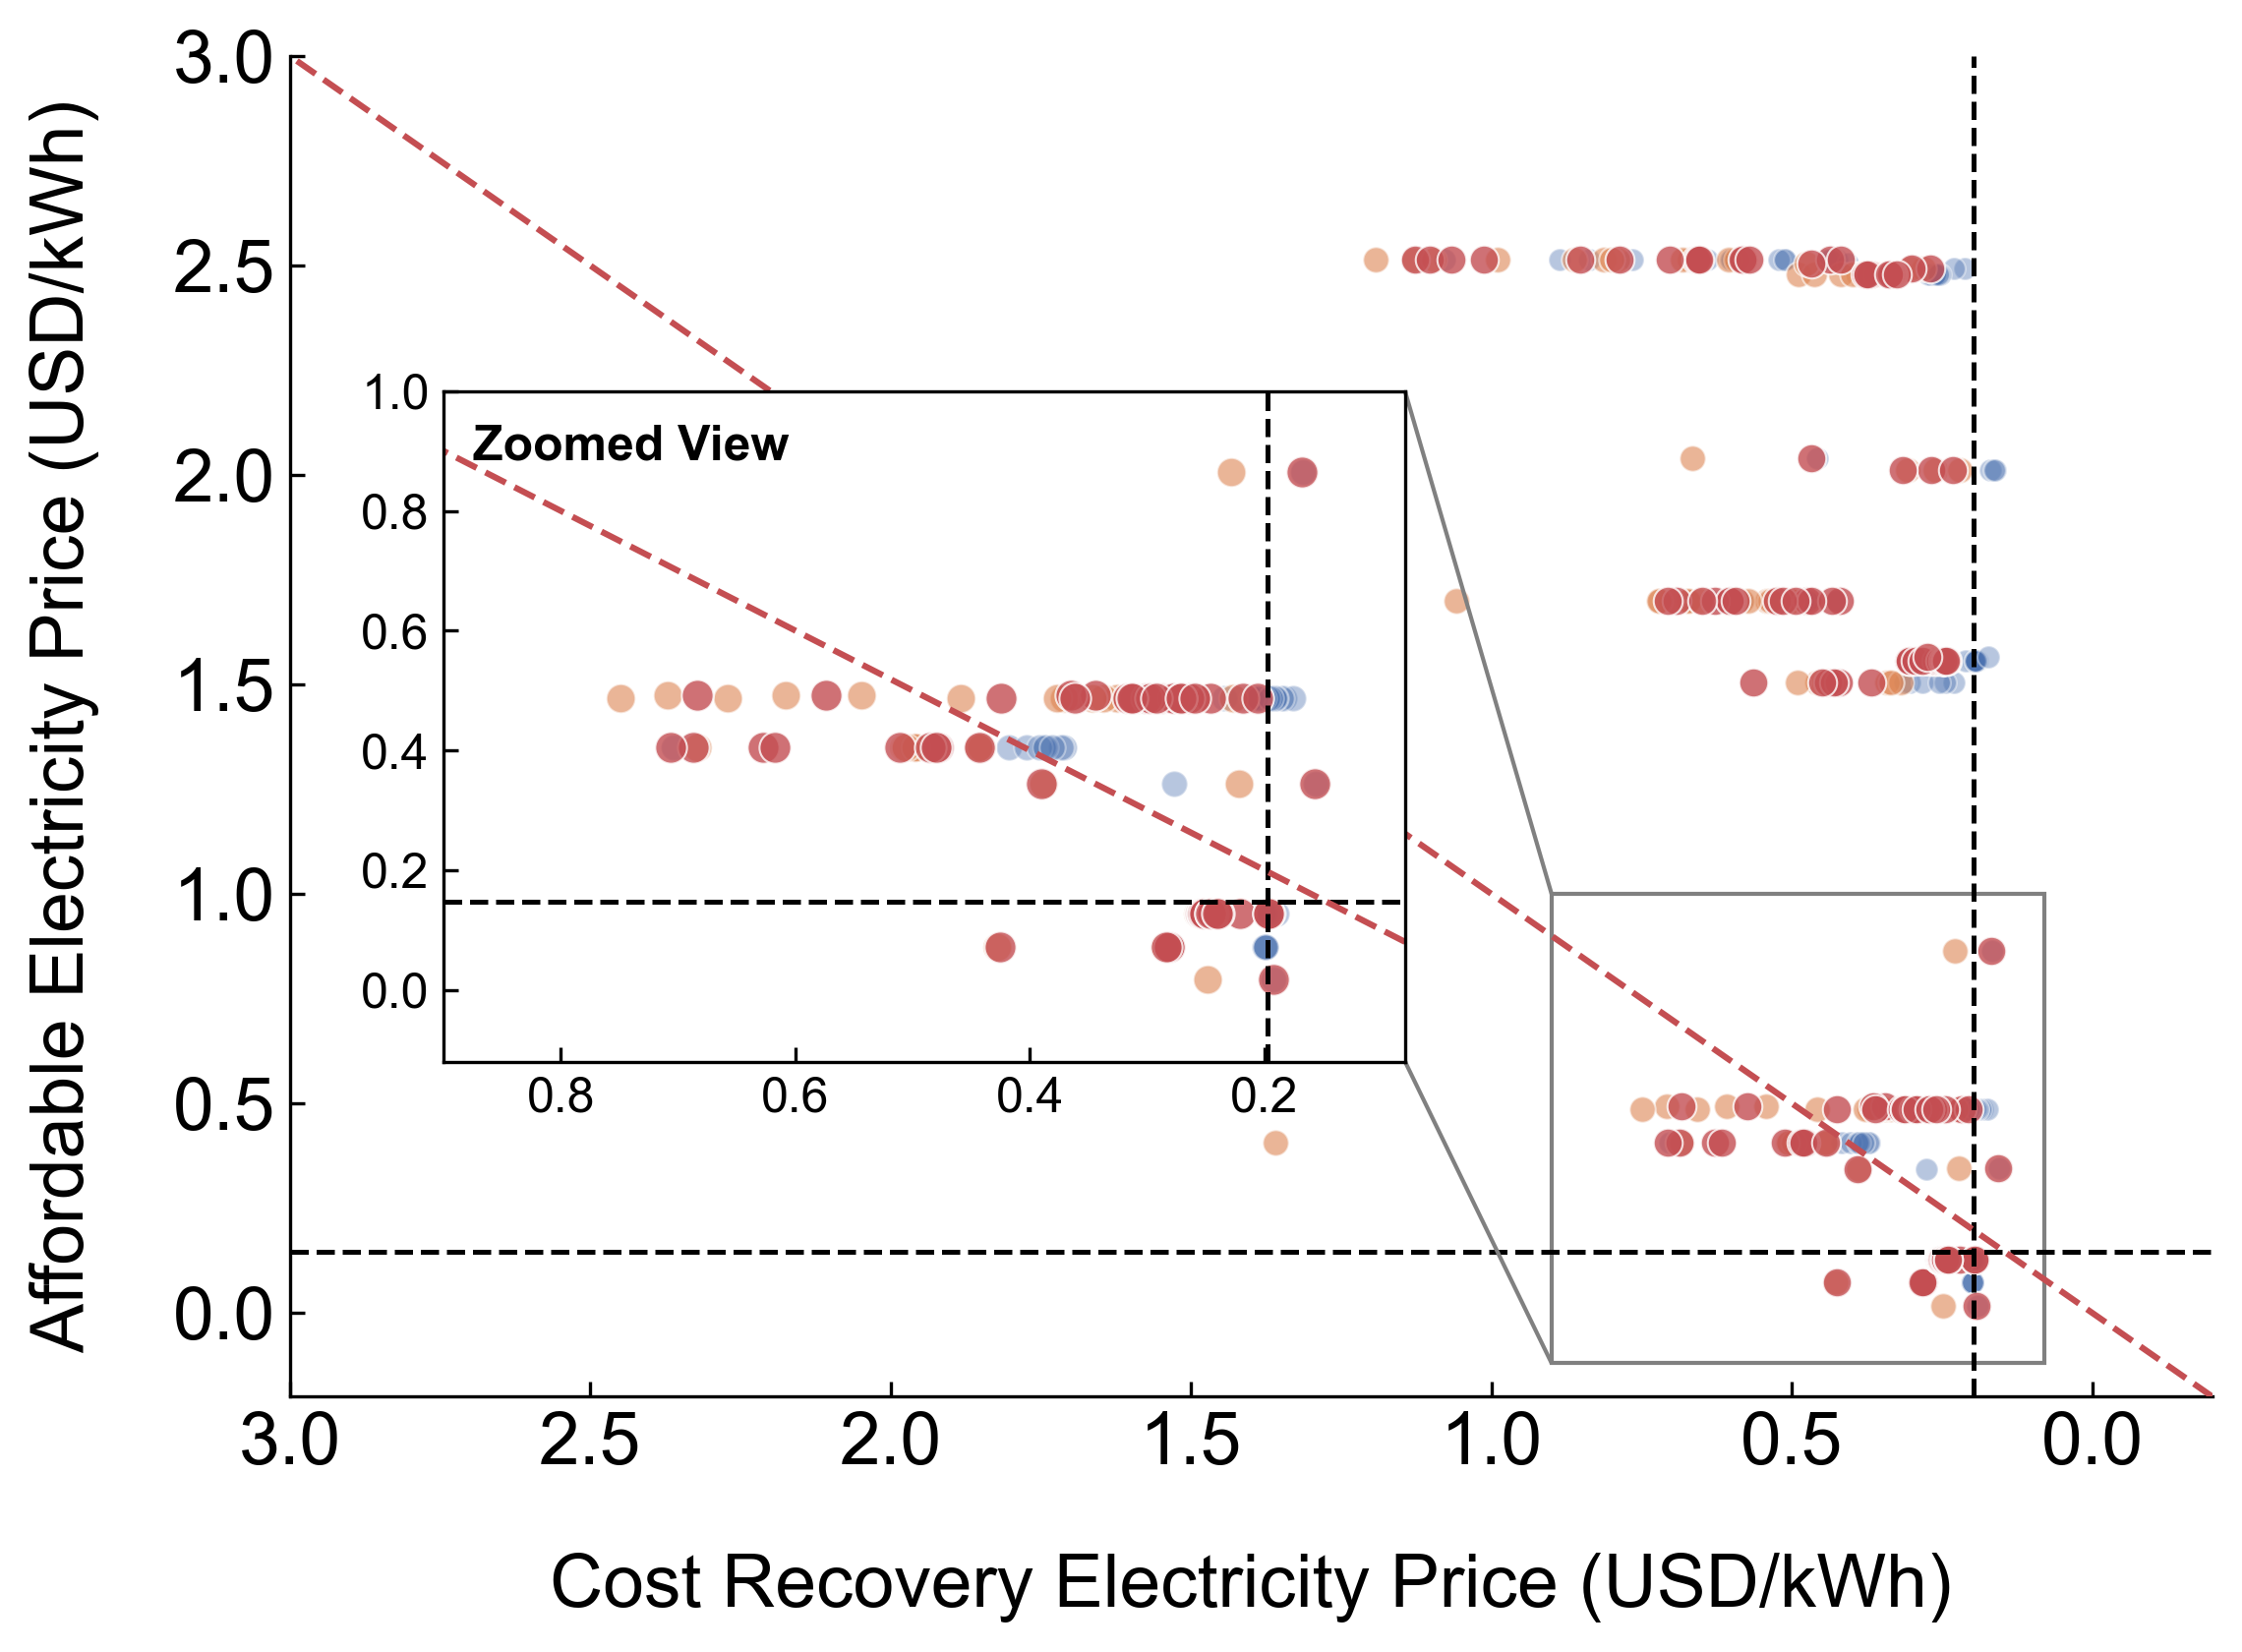


--- 统计分析结果 (仅针对显著变化的岛屿) ---
                High Affordable \nLow Cost  High Affordable \nHigh Cost  \
Scenario                                                                  
Ideal                                   28                          108   
Baseline                                 0                          136   
Climate Stress                           2                          134   

                Low Affordable \nLow Cost  Low Affordable \nHigh Cost  \
Scenario                                                                
Ideal                                  21                          14   
Baseline                                0                          35   
Climate Stress                          3                          32   

                Unaffordable  
Scenario                      
Ideal                     37  
Baseline                  50  
Climate Stress            47  
--------------------------------------------------


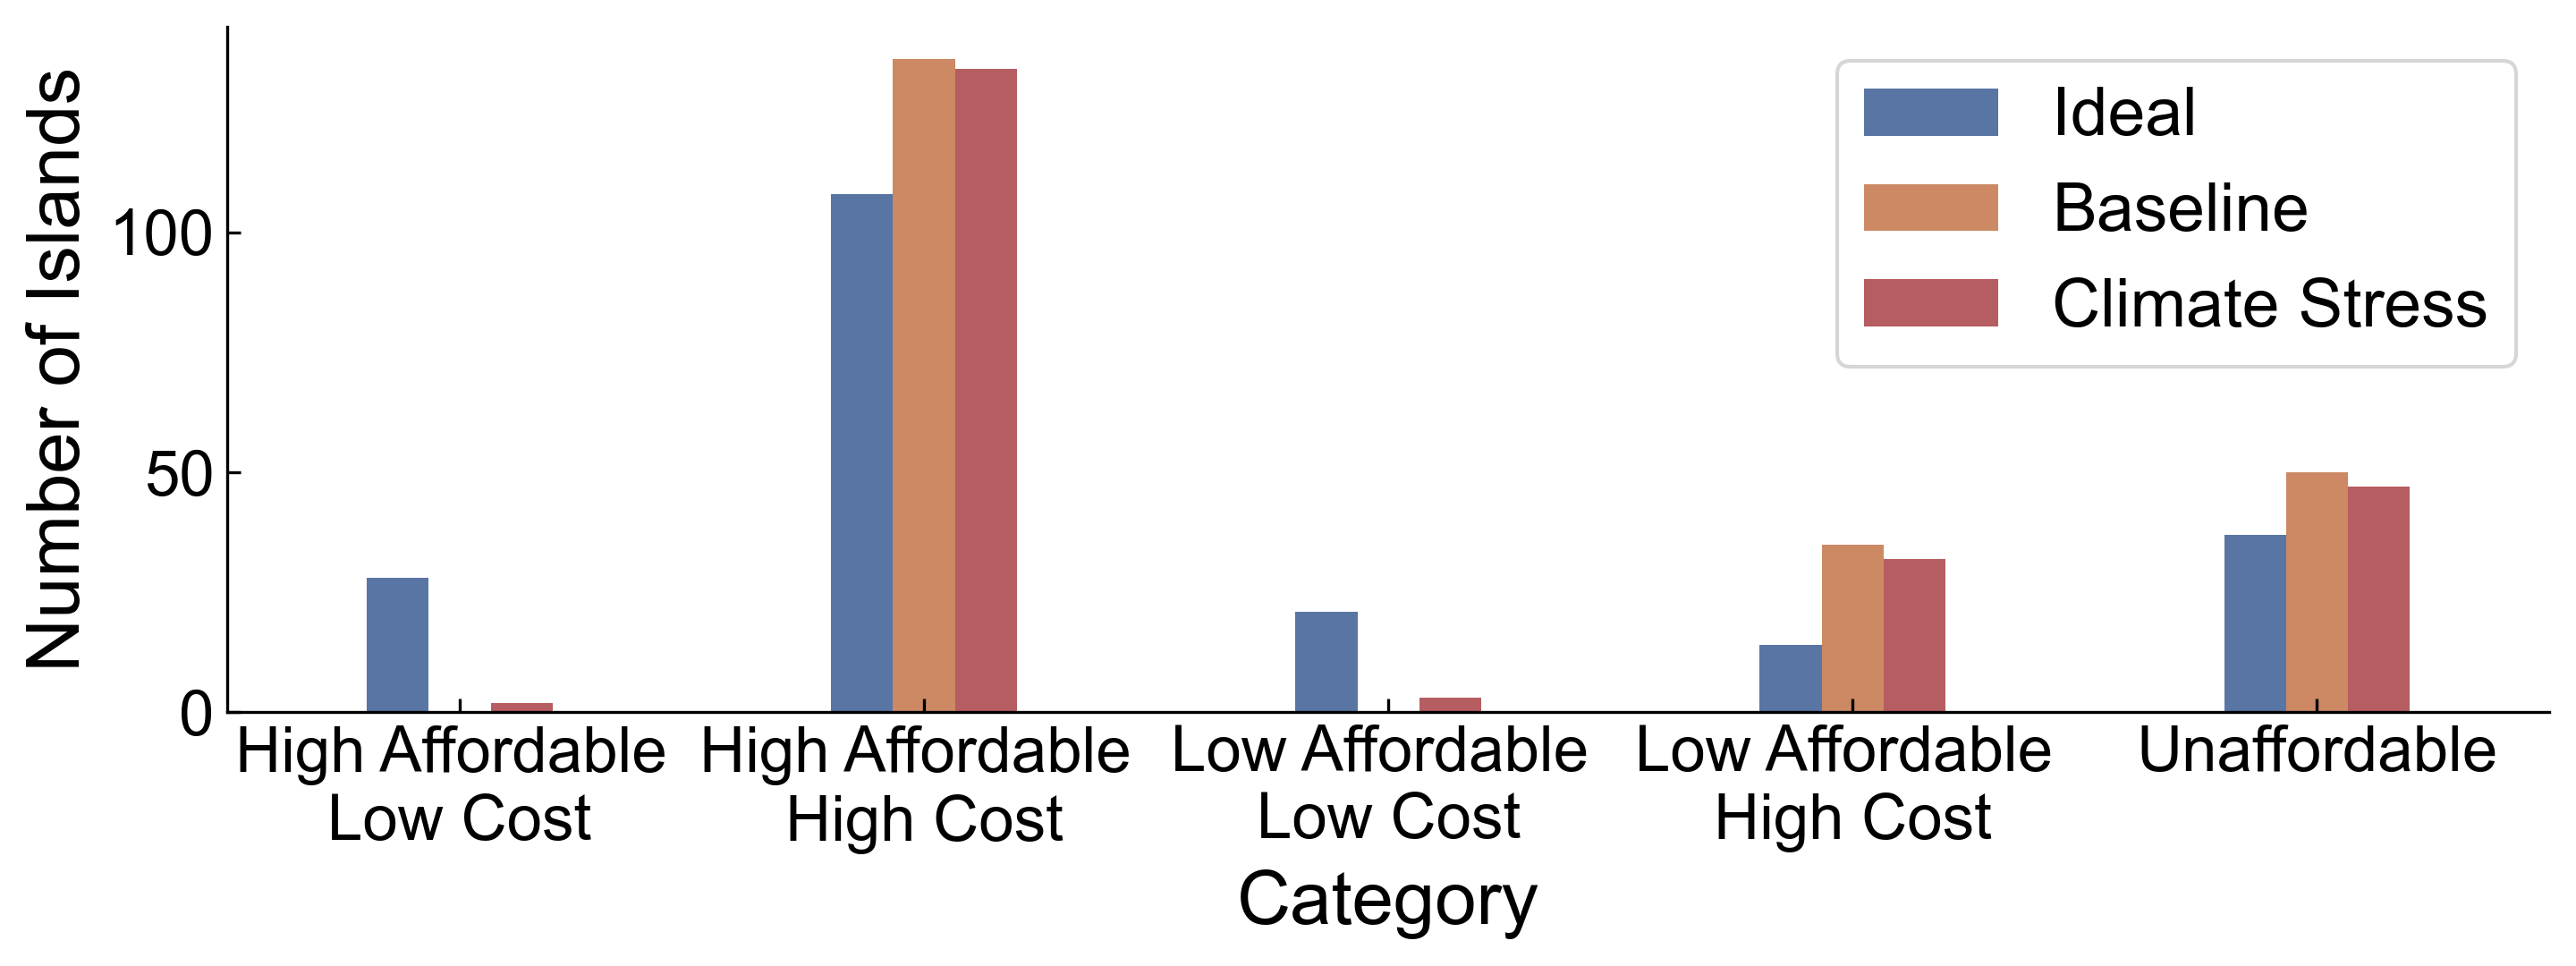

In [96]:
# --- Nature 风格图表设置 ---
# 在绘图前全局设置字体、字号等参数
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 20,  # 基础字号可以稍小，具体元素再调整
    'axes.labelsize': 18,
    'axes.titlesize': 16,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'figure.dpi': 300,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.direction': 'in', # 刻度线朝内
    'ytick.direction': 'in', # 刻度线朝内
})


# --- NEW: 新增的统计分析与绘图函数 ---
def analyze_and_plot_statistics(df_analysis, scenario_config, median_breakeven, median_affordable):
    """
    对数据进行象限和可负担性分析，并绘制条形图。
    """
    results = []
    
    # 1. 遍历每个情景进行统计
    for scenario_name, config in scenario_config.items():
        scenario_df = df_analysis[df_analysis['scenario'] == scenario_name].copy()
        if scenario_df.empty:
            continue
            
        # 定义象限条件
        is_viable = (scenario_df['tariff_breakeven'] <= median_breakeven) & (scenario_df['tariff_affordable'] >= median_affordable)
        is_marginal = (scenario_df['tariff_breakeven'] >= median_breakeven) & (scenario_df['tariff_affordable'] >= median_affordable)
        is_limited = (scenario_df['tariff_breakeven'] <= median_breakeven) & (scenario_df['tariff_affordable'] <= median_affordable)
        is_challenging = (scenario_df['tariff_breakeven'] >= median_breakeven) & (scenario_df['tariff_affordable'] <= median_affordable)
        is_unaffordable = scenario_df['tariff_breakeven'] >= scenario_df['tariff_affordable']
        
        # 统计数量
        counts = {
            'Scenario': config['label'],
            'High Affordable \nLow Cost': is_viable.sum(),
            'High Affordable \nHigh Cost': is_marginal.sum(),
            'Low Affordable \nLow Cost': is_limited.sum(),
            'Low Affordable \nHigh Cost': is_challenging.sum(),
            'Unaffordable': is_unaffordable.sum()
        }
        results.append(counts)
        
    if not results:
        print("没有可供分析的数据。")
        return
        
    # 2. 创建并打印统计结果的DataFrame
    stats_df = pd.DataFrame(results).set_index('Scenario')
    print("\n--- 统计分析结果 (仅针对显著变化的岛屿) ---")
    print(stats_df)
    print("-" * 50)
    
    # 3. 准备绘图数据
    stats_df_melted = stats_df.reset_index().melt(
        id_vars='Scenario',
        var_name='Category',
        value_name='Number of Islands'
    )
    
    # 提取颜色用于绘图
    palette = {config['label']: config['color'] for config in scenario_config.values()}
    
    # 定义nature系列的颜色调色板（5种颜色）
    nature_colors = ['#2E8B57', '#FF8C00', '#4682B4', '#DC143C', '#8B4513']  # 森林绿、橙、钢蓝、深红、棕色
    
    # 4. 创建条形图
    fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
    
    # 使用seaborn绘制条形图
    bars = sns.barplot(
        data=stats_df_melted,
        x='Category',
        y='Number of Islands',
        hue='Scenario',
        palette=palette,
        ax=ax,
        width=0.4
    )
    
    # 美化图表
    # ax.set_title(f'Statistical Distribution of Islands by Category ({scenario_name})', fontsize=14, pad=15)
    ax.set_xlabel('Category', fontsize=20)
    ax.set_ylabel('Number of Islands', fontsize=20)
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', labelsize=17)
    ax.legend()  # 移除title='Scenario'
    
    # 在条形图上添加数字标签
    # for p in ax.patches:
    #     height = p.get_height()
    #     if height > 0:  # 只在非零值上添加标签
    #         ax.annotate(f'{int(height)}', 
    #                     (p.get_x() + p.get_width() / 2., height), 
    #                     ha='center', va='center', 
    #                     xytext=(0, 9), 
    #                     textcoords='offset points',
    #                     fontsize=16)

    fig.tight_layout()
    plt.show()

# --- 核心绘图函数（修改为plot_feasibility_quadrant样式） ---
def plot_three_scenario_changes(df, base_scenario, final_scenario, zoom_config, scenario_config, change_threshold=0.1):
    """
    筛选出在首尾情景间有显著变化的岛屿，绘制它们的位置，并进行统计分析。
    使用plot_feasibility_quadrant的样式。
    """
    if df.empty:
        print("数据为空，跳过绘图。")
        return

    # 1. 筛选出用于计算变化的起始和最终情景数据
    df_base = df[df['scenario'] == base_scenario]
    df_final = df[df['scenario'] == final_scenario]
    
    if df_base.empty or df_final.empty:
        print(f"缺少 {base_scenario} 或 {final_scenario} 的数据，无法计算变化。")
        return

    # 2. 计算并筛选出有显著变化的岛屿
    change_data = calculate_position_change(df_base, df_final)
    significant_changes = change_data[change_data['position_change'] > change_threshold]
    
    if significant_changes.empty:
        print(f"在阈值 {change_threshold} 下未发现显著变化的岛屿。")
        return
        
    significant_island_ids = significant_changes['island_id'].unique()
    print(f"发现 {len(significant_island_ids)} 个有显著变化的岛屿（在 {base_scenario} 和 {final_scenario} 之间）。")

    # 3. 从原始数据中筛选出这些岛屿在 *所有情景* 中的数据
    df_plot = df[df['island_id'].isin(significant_island_ids)].copy()

    # === 使用plot_feasibility_quadrant的样式 ===
    fig, ax = plt.subplots(figsize=(8, 6),dpi=300)  # 使用相同的图形尺寸

    # --- 绘制主散点图 ---
    for scenario_name, config in scenario_config.items():
        scenario_df = df_plot[df_plot['scenario'] == scenario_name]
        if not scenario_df.empty:
            ax.scatter(scenario_df['tariff_breakeven'], scenario_df['tariff_affordable'],
                       color=config['color'],
                       label=config['label'],
                       alpha=config['alpha'], s=config['size'], edgecolors='white', linewidth=0.5, zorder=3)

    # --- 设置坐标轴和标题 ---
    ax.set_xlabel('Cost Recovery Electricity Price (USD/kWh)', labelpad=18)  # 使用相同的标签和间距
    ax.set_ylabel('Affordable Electricity Price (USD/kWh)', labelpad=18)
    # ax.set_title(f'Island Energy System Feasibility ({scenario_name})', weight='bold', size=12)

    # --- 翻转横轴，让低成本在右边 ---
    ax.invert_xaxis()  # 添加横轴翻转

    # --- "Despine" - 移除顶部和右侧轴线 ---
    ax.spines[['right', 'top']].set_visible(False)

    # --- 添加辅助线 ---
    median_breakeven = df_base['tariff_breakeven'].median()  # 使用基础情景的中位数
    median_affordable = df_base['tariff_affordable'].median()
    ax.axvline(x=median_breakeven, color='black', linestyle='--', linewidth=1.2, zorder=3)  # 使用相同的线条样式
    ax.axhline(y=median_affordable, color='black', linestyle='--', linewidth=1.2, zorder=3)

    ax.set_xlim(3, -0.2)
    ax.set_ylim(-0.2, 3)

    # 45度线
    lim_min = min(ax.get_xlim()[0], ax.get_ylim()[0])
    lim_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([lim_min, lim_max], [lim_min, lim_max], color='#C44E52', linestyle='--', 
              alpha=1, linewidth=1.5, label='Break-even line', zorder=3)  # 使用相同的45度线样式
    ax.grid(False)  # 关闭网格

    # --- 创建放大视图 ---
    zoom_data = df_plot[
        (df_plot['tariff_breakeven'].between(zoom_config['x_min'], zoom_config['x_max'])) &
        (df_plot['tariff_affordable'].between(zoom_config['y_min'], zoom_config['y_max']))
    ]
    
    if not zoom_data.empty:
        # 创建主子图
        inset_ax = ax.inset_axes([0.08, 0.25, 0.5, 0.5])  # 使用相同的放大视图位置和大小
        
        # 创建divider来添加边际图
        # divider = make_axes_locatable(inset_ax)
        
        # # 添加上方和右方的边际图
        # ax_top = divider.append_axes("top", size="25%", pad=0.05, sharex=inset_ax)
        # ax_right = divider.append_axes("right", size="25%", pad=0.05, sharey=inset_ax)
        
        # 隐藏边际图的刻度标签
        # plt.setp(ax_top.get_xticklabels(), visible=False)
        # plt.setp(ax_right.get_yticklabels(), visible=False)
        
        # 绘制主散点图
        for scenario_name, config in scenario_config.items():
            zoom_scenario_data = zoom_data[zoom_data['scenario'] == scenario_name]
            if not zoom_scenario_data.empty:
                inset_ax.scatter(zoom_scenario_data['tariff_breakeven'], zoom_scenario_data['tariff_affordable'],
                                 color=config['color'], alpha=config['alpha'], s=config['size'] + 10, 
                                 edgecolors='white', linewidth=0.5)

        # 中位线
        inset_ax.axvline(x=median_breakeven, color='black', linestyle='--', linewidth=1.2, zorder=1)
        inset_ax.axhline(y=median_affordable, color='black', linestyle='--', linewidth=1.2, zorder=1)
        
        # 在小图中添加 y=x 线
        inset_lim_min = max(zoom_config['x_min'], zoom_config['y_min'])
        inset_lim_max = min(zoom_config['x_max'], zoom_config['y_max'])
        inset_ax.plot([inset_lim_min, inset_lim_max], [inset_lim_min, inset_lim_max], 
                      color='#C44E52', linestyle='--', alpha=1, linewidth=1.5, zorder=1)
        
        # 设置放大视图范围和样式
        inset_ax.set_xlim(zoom_config['x_min'], zoom_config['x_max'])
        inset_ax.set_ylim(zoom_config['y_min'], zoom_config['y_max'])
        inset_ax.tick_params(labelsize=12)
        inset_ax.grid(False)
        
        # 翻转放大子图的横轴
        inset_ax.invert_xaxis()
        
        # --- 添加密度曲线 ---
        # 上方密度图 (x轴密度)
        # x_data = zoom_data['tariff_breakeven']
        # if len(x_data) > 1:
        #     # 使用核密度估计
        #     kde_x = stats.gaussian_kde(x_data)
        #     x_range = np.linspace(zoom_config['x_min'], zoom_config['x_max'], 100)
        #     density_x = kde_x(x_range)
        #     ax_top.plot(x_range, density_x, color='#2E8B57', linewidth=2)
        #     ax_top.fill_between(x_range, density_x, alpha=0.3, color='#2E8B57')
        #     ax_top.set_xlim(zoom_config['x_min'], zoom_config['x_max'])
        #     # 让上方密度图背景透明
        #     ax_top.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        #     ax_top.set_yticks([])
        #     ax_top.set_facecolor('none')  # 设置背景透明
        #     # 翻转上方密度图的横轴
        #     ax_top.invert_xaxis()
        
        # # 右侧密度图 (y轴密度)
        # y_data = zoom_data['tariff_affordable']
        # if len(y_data) > 1:
        #     kde_y = stats.gaussian_kde(y_data)
        #     y_range = np.linspace(zoom_config['y_min'], zoom_config['y_max'], 100)
        #     density_y = kde_y(y_range)
        #     ax_right.plot(density_y, y_range, color='#FF8C00', linewidth=2)
        #     ax_right.fill_betweenx(y_range, density_y, alpha=0.3, color='#FF8C00')
        #     ax_right.set_ylim(zoom_config['y_min'], zoom_config['y_max'])
        #     # 让右侧密度图背景透明
        #     ax_right.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
        #     ax_right.set_xticks([])
        #     ax_right.set_facecolor('none')  # 设置背景透明
        
        inset_ax.text(0.03, 0.95, 'Zoomed View', transform=inset_ax.transAxes, 
                      ha='left', va='top', fontsize=12, weight='bold')

        # 添加连接线
        mark_inset(ax, inset_ax, loc1=1, loc2=4, fc="none", ec="0.5")

    # --- 图例和显示 ---
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))  # 不显示图例，将在最后单独生成
    
    # --- 调整并保存/显示 ---
    fig.tight_layout()
    plt.show()

    # --- MODIFIED: 调用新的分析函数 ---
    analyze_and_plot_statistics(df_plot, scenario_config, median_breakeven, median_affordable)


# ===== 主程序 =====
if __name__ == '__main__':
    # 检查ipcc_region列是否存在
    if 'ipcc_region' not in df.columns:
        print("错误：ipcc_region列不存在，无法执行分析")
    else:
        print(f"ipcc_region列已存在，开始分析...")
        
        # --- 2. 绘图配置 ---
        ZOOM_BOX = {
            'x_min': 0.08, 'x_max': 0.9,  # 使用与plot_feasibility_quadrant相同的放大视图配置
            'y_min': -0.12, 'y_max': 1
        }

        SCENARIO_CONFIG = {
            'output_0': {
                'label': 'Ideal',
                'color': '#4C72B0',  # Blue
                'alpha': 0.4,  # 调整透明度与plot_feasibility_quadrant一致
                'size': 30,  # 调整点大小与plot_feasibility_quadrant一致
                'zorder': 2
            },
            'output_2020': {
                'label': 'Baseline',
                'color': '#DD8452',  # Orange
                'alpha': 0.6,
                'size': 40,
                'zorder': 3
            },
            'output_2050': {
                'label': 'Climate Stress',
                'color': '#C44E52',  # Red
                'alpha': 0.8,
                'size': 50,
                'zorder': 4
            }
        }

        # --- 3. 筛选并绘图 ---
        scenarios_to_plot = list(SCENARIO_CONFIG.keys())
        df_filtered = df[df['scenario'].isin(scenarios_to_plot)].copy()

        print(f"\n--- 正在对比三个情景，但只显示在 'output_0' 和 'output_2020' 之间有显著变化的岛屿 ---")
        
        if not df_filtered.empty:
            plot_three_scenario_changes(
                df=df_filtered,
                base_scenario='output_0',
                final_scenario='output_2020',
                zoom_config=ZOOM_BOX,
                scenario_config=SCENARIO_CONFIG,
                change_threshold=0.05 
            )
        else:
            print("没有足够的数据用于绘图。")

开始创建点密度世界地图...
发现 171 个有显著变化的岛屿
显著变化岛屿的IPCC区域分布:
ipcc_region
NEU    37
SEA    29
EAS    27
SWS    22
NWN    16
WNA     8
RFE     7
NPO     6
SSA     5
BOB     3
ENA     3
SAU     2
NZ      2
SPO     1
GIC     1
MDG     1
NAU     1
Name: count, dtype: int64


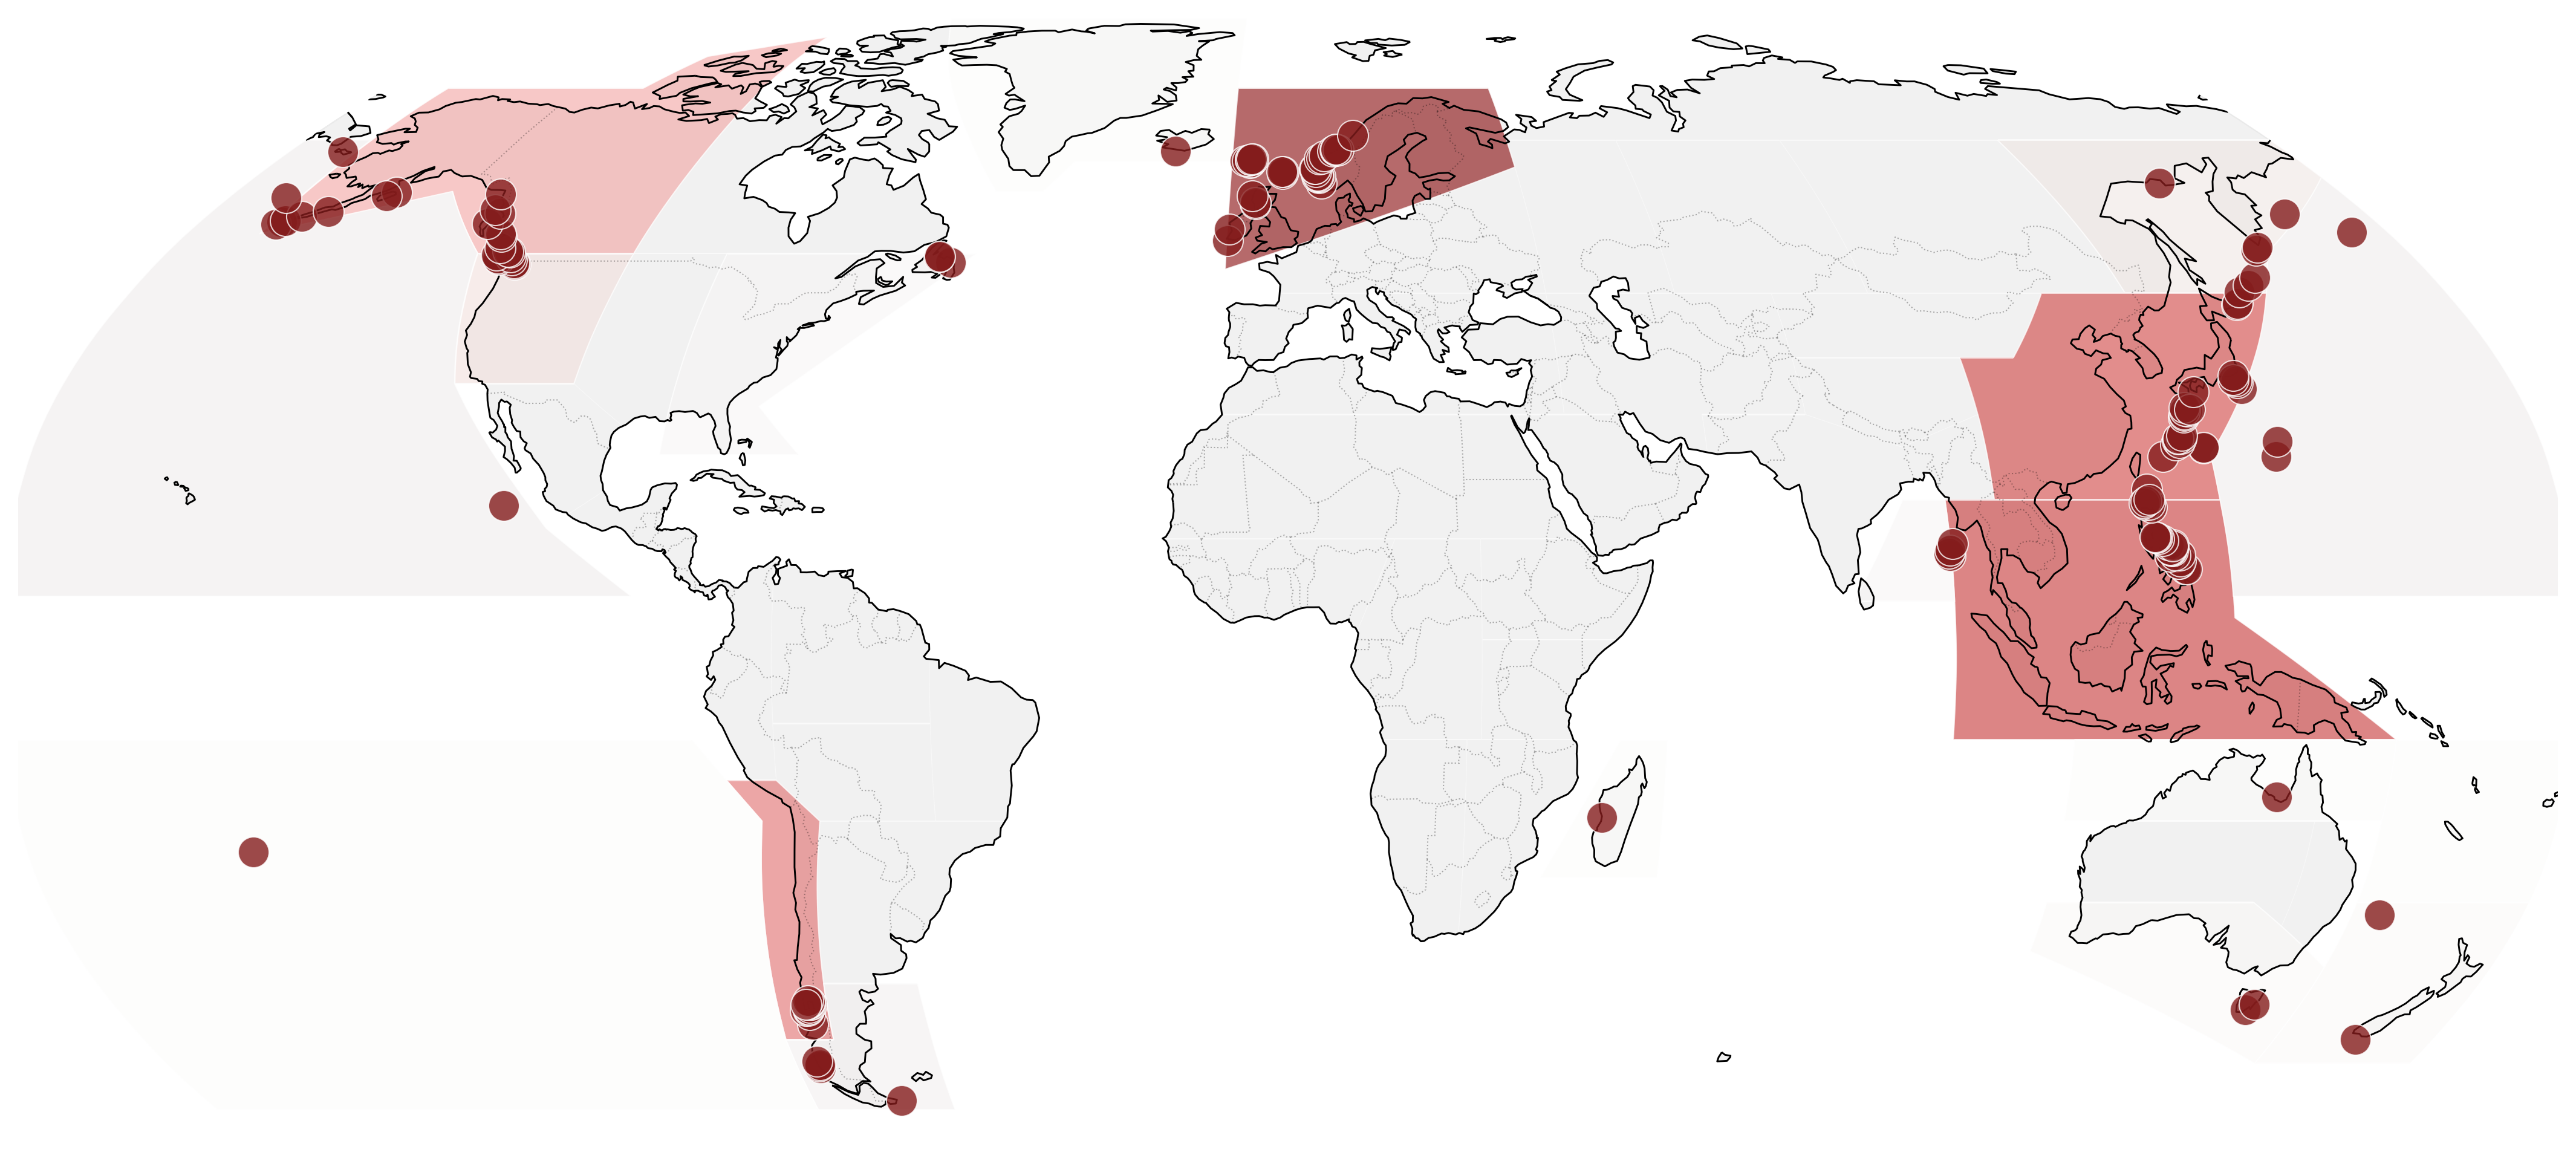


=== 世界地图统计摘要 ===
总共标记了 171 个有显著变化的岛屿
涉及 17 个IPCC区域
变化最多的区域: NEU (37 个岛屿)


In [97]:
# 7. --- 基于有明显变化岛屿的点密度世界地图 ---

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter

print("开始创建点密度世界地图...")

# 计算岛屿变化数据
df_base = df[(df['scenario'] == 'output_0')].copy()
df_compare = df[(df['scenario'] == 'output_2020')].copy()

# 使用现有的calculate_position_change函数
change_data = calculate_position_change(df_base, df_compare)
significant_changes = change_data[change_data['position_change'] > 0.05]  # 显著变化阈值

print(f"发现 {len(significant_changes)} 个有显著变化的岛屿")

if len(significant_changes) > 0:
    # 获取有显著变化岛屿的位置信息
    significant_islands = df_base[df_base['island_id'].isin(significant_changes['island_id'])].copy()
    
    print(f"显著变化岛屿的IPCC区域分布:")
    region_counts = significant_islands['ipcc_region'].value_counts()
    print(region_counts)
    
    # 读取IPCC区域地理数据
    ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")

    # 创建世界地图
    fig = plt.figure(figsize=(14, 8.5), dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

    # 设置背景和地图特征
    ax.set_facecolor("#FFFFFF")
    ax.add_feature(cfeature.LAND, color="#CECECE", alpha=0.4)
    ax.add_feature(cfeature.OCEAN, color="#FFFFFF", alpha=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, alpha=0.3)
    
    # 计算每个IPCC区域的显著变化岛屿数量
    if not region_counts.empty:
        # 创建红色渐变色彩映射（白色到深红色）
        vmin, vmax = region_counts.min(), region_counts.max()
        norm = Normalize(vmin=0, vmax=vmax)  # 从0开始，确保没有岛屿的区域为白色
        
        # 创建自定义红色渐变色彩映射
        colors = ['#FFFFFF', '#F1EEED', '#FCCDC9', '#EE9D9F', '#DE6A69', '#C84747', '#982B2D']  # 白色到深红色渐变
        red_colormap = LinearSegmentedColormap.from_list('red_gradient', colors, N=256)
        
        # 为每个IPCC区域着色
        for _, region_row in ipcc_regions.iterrows():
            region_code = region_row['Acronym']
            
            if region_code in region_counts.index:
                # 该区域有显著变化的岛屿
                island_count = region_counts[region_code]
                color = red_colormap(norm(island_count))
                alpha = 0.7  # 有数据的区域更不透明
                
                # 绘制填充的区域
                ax.add_geometries([region_row['geometry']], crs=ccrs.PlateCarree(),
                                  facecolor=color,
                                  edgecolor='white',
                                  linewidth=0.5,
                                  alpha=alpha,
                                  zorder=1)
            else:
                # 该区域没有显著变化的岛屿，保持浅色
                ax.add_geometries([region_row['geometry']], crs=ccrs.PlateCarree(),
                                  facecolor='white',
                                  edgecolor="#FFFFFF",
                                  linewidth=0.3,
                                  alpha=0.3,
                                  zorder=1)
    
    # 在地图上标注显著变化的岛屿点
    if not significant_islands.empty:
        # 使用深红色圆点标记有显著变化的岛屿
        ax.scatter(significant_islands['lon'], significant_islands['lat'],
                   transform=ccrs.PlateCarree(),  # 坐标转换
                   c="#841C1C",  # 深红色点
                   s=150,  # 点大小参数，控制岛屿标记的大小
                   alpha=0.8,  # 透明度参数，让点更加明显
                   edgecolors='white',  # 白色边框
                   linewidth=0.5,  # 边框宽度参数
                   zorder=3)  # 确保点显示在最上层
    
    # 设置视图范围，排除南极洲
    ax.set_extent([-180, 180, -60, 85], crs=ccrs.PlateCarree())
    
    # 添加颜色条图例
    # if not region_counts.empty:
    #     # 创建颜色条
    #     sm = cm.ScalarMappable(norm=norm, cmap=red_colormap)
    #     sm.set_array([])
        
    #     # 在右侧添加颜色条
    #     cbar = plt.colorbar(sm, ax=ax, orientation='vertical', 
    #                        pad=0.02, shrink=0.6, aspect=20)
    #     cbar.set_label('Number of Islands with Significant Changes', 
    #                    rotation=270, labelpad=20, fontsize=20)  # 颜色条标签
    #     cbar.ax.tick_params(labelsize=10)  # 颜色条刻度标签大小参数
    
    # 添加标题
    # ax.set_title('Global Distribution of Islands with Significant Tariff Changes\n(Baseline vs Climate Stress Scenarios)', 
    #              fontsize=14, fontweight='bold', pad=20)
    
    # 去除坐标轴刻度
    ax.set_xticks([])
    ax.set_yticks([])
    # 去除边框
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # 去除所有边距，只显示图像内容
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.axis('off')
    plt.show()
    
    # 打印统计摘要
    print(f"\n=== 世界地图统计摘要 ===")
    print(f"总共标记了 {len(significant_islands)} 个有显著变化的岛屿")
    print(f"涉及 {len(region_counts)} 个IPCC区域")
    print(f"变化最多的区域: {region_counts.index[0]} ({region_counts.iloc[0]} 个岛屿)")
    
else:
    print("没有发现显著变化的岛屿，无法创建地图可视化")

In [116]:
# 使用 floweaver 和 holoviews 创建四列连续桑基图
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path
import matplotlib

# 设置全局字体为Arial
plt.rcParams.update({
    'font.family': 'Arial',  # 设置字体为Arial
    'font.size': 16,  # 基础字体大小
})

# =============================================================================
# 数据预处理部分 - 三个情景的四列桑基图数据准备
# =============================================================================

# 1. 读取岛屿可行性分析数据
data_path = Path("../result/island_viability_summary_electric.csv")
df = pd.read_csv(data_path)  # 加载原始数据
print(f"原始数据形状: {df.shape}")  # 显示数据维度信息

# 2. 加载IPCC区域地理数据用于区域分配
try:
    ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")  # 加载IPCC区域边界数据
    ipcc_regions.sindex  # 创建空间索引以加速地理查询
    print("IPCC区域地理数据加载成功")
except Exception as e:
    print(f"无法加载IPCC区域数据: {e}")
    ipcc_regions = None

# 3. 定义IPCC区域分配函数（高效版本）
def assign_ipcc_region_optimized(lat, lon, ipcc_regions_gdf):
    """使用空间索引高效地将坐标分配到IPCC区域"""
    point = Point(lon, lat)  # 创建点几何对象
    possible_matches_index = list(ipcc_regions_gdf.sindex.intersection(point.bounds))  # 空间索引快速筛选
    possible_matches = ipcc_regions_gdf.iloc[possible_matches_index]  # 获取可能匹配的区域
    precise_matches = possible_matches[possible_matches.contains(point)]  # 精确几何匹配
    if not precise_matches.empty:
        return precise_matches.iloc[0]['Acronym']  # 返回区域简称
    return 'Unknown'  # 未匹配到区域时返回Unknown

# 4. 定义变化计算函数（与上面cell保持一致）
def calculate_position_change(df_base, df_compare):
    """计算两个情景之间的位置变化 - 修正版，包含IPCC区域信息"""
    # 修正：合并时包含ipcc_region信息
    merged = pd.merge(df_base[['island_id', 'tariff_breakeven', 'ipcc_region']],
                      df_compare[['island_id', 'tariff_breakeven']],
                      on='island_id', suffixes=('_base', '_compare'))
    merged['position_change'] = abs(merged['tariff_breakeven_compare'] - merged['tariff_breakeven_base'])
    # 重命名ipcc_region列以保持一致性
    merged = merged.rename(columns={'ipcc_region': 'ipcc_region_base'})
    return merged

# 5. 为整个数据集分配IPCC区域（与上面cell保持一致）
if ipcc_regions is not None:
    print("正在为岛屿分配IPCC区域...")
    df['ipcc_region'] = df.apply(
        lambda row: assign_ipcc_region_optimized(row['lat'], row['lon'], ipcc_regions), axis=1
    )  # 应用区域分配函数
    print(f"区域分配完成，涉及区域: {df['ipcc_region'].nunique()}")
else:
    df['ipcc_region'] = 'Unknown'  # 如果没有区域数据，设为Unknown

# =============================================================================
# NEW: 先筛选在2020年scenario有显著变化的岛屿
# =============================================================================

print("\n=== 筛选在2020年scenario有显著变化的岛屿 ===")

# 获取Ideal和2020年scenario的数据
df_ideal = df[df['scenario'] == 'output_0'].copy()  # Ideal情景数据
df_2020 = df[df['scenario'] == 'output_2020'].copy()  # 2020年情景数据

# 计算变化
change_data = calculate_position_change(df_ideal, df_2020)
significant_threshold = 0.05  # 显著变化阈值
significant_changes = change_data[change_data['position_change'] > significant_threshold]

print(f"原始岛屿总数: {len(df_ideal)}")
print(f"在2020年scenario有显著变化的岛屿数: {len(significant_changes)}")
print(f"显著变化阈值: {significant_threshold}")

# 获取有显著变化的岛屿ID列表
significant_island_ids = significant_changes['island_id'].unique()
print(f"有显著变化的唯一岛屿数: {len(significant_island_ids)}")

# 从原始数据中筛选出这些有显著变化的岛屿
df_filtered = df[df['island_id'].isin(significant_island_ids)].copy()
print(f"筛选后的数据形状: {df_filtered.shape}")

# =============================================================================
# 6. 在有显著变化的岛屿中，再筛选有效区域（岛屿数量阈值）
# =============================================================================

print("\n=== 在有显著变化的岛屿中应用区域数量阈值 ===")

MIN_ISLANDS_PER_REGION = 10  # 每个区域最少岛屿数量阈值

# 统计有显著变化的岛屿在各区域的分布
region_counts_filtered = df_filtered['ipcc_region'].value_counts()  # 统计各区域岛屿数量
valid_regions = region_counts_filtered[region_counts_filtered > MIN_ISLANDS_PER_REGION].index.tolist()  # 筛选有效区域

print(f"有显著变化岛屿的区域分布:")
print(region_counts_filtered.head(10))
print(f"满足数量阈值的有效区域 (岛屿数量>{MIN_ISLANDS_PER_REGION}): {len(valid_regions)} 个")
print(f"有效区域列表: {valid_regions}")

# 最终筛选：既有显著变化又在有效区域的岛屿
df_final = df_filtered[df_filtered['ipcc_region'].isin(valid_regions)].copy()
final_island_ids = df_final['island_id'].unique()

print(f"最终用于桑基图的岛屿数: {len(final_island_ids)}")
print(f"最终数据形状: {df_final.shape}")

# =============================================================================
# 7. 定义象限分类函数
# =============================================================================

def classify_quadrant(row, median_breakeven, median_affordable):
    """根据电价中位数将岛屿分类到四个象限"""
    breakeven = row['tariff_breakeven']  # 盈亏平衡电价
    affordable = row['tariff_affordable']  # 可负担电价

    if affordable > median_affordable and breakeven <= median_breakeven:
        return 'High Affordable\\nLow Cost'  # 高可负担性、低成本
    elif affordable > median_affordable and breakeven > median_breakeven:
        return 'High Affordable\\nHigh Cost'  # 高可负担性、高成本
    elif affordable <= median_affordable and breakeven <= median_breakeven:
        return 'Low Affordable\\nLow Cost'  # 低可负担性、低成本
    else:
        return 'Low Affordable\\nHigh Cost'  # 低可负担性、高成本

# =============================================================================
# 8. 处理三个情景的数据并计算各自的中位数分类
# =============================================================================

scenarios = ['output_0', 'output_2020', 'output_2050']  # 三个主要情景
scenario_labels = ['Ideal', 'Baseline', 'Climate Stress']  # 情景标签

# 准备合并数据的列表
combined_data = []

# 为每个情景计算中位数并分类（只针对最终筛选的岛屿）
for scenario in scenarios:
    df_scenario = df_final[df_final['scenario'] == scenario].copy()  # 筛选情景数据

    # 计算该情景下的中位数阈值
    median_breakeven = df_scenario['tariff_breakeven'].median()  # 盈亏平衡电价中位数
    median_affordable = df_scenario['tariff_affordable'].median()  # 可负担电价中位数

    # 应用象限分类
    df_scenario['quadrant'] = df_scenario.apply(
        lambda row: classify_quadrant(row, median_breakeven, median_affordable), axis=1
    )  # 为每个岛屿分配象限

    print(f"情景 {scenario}: 有效岛屿数 {len(df_scenario)}, 中位数 - 盈亏平衡: {median_breakeven:.3f}, 可负担: {median_affordable:.3f}")

    combined_data.append(df_scenario)

# =============================================================================
# 9. 创建四列桑基图的数据结构
# =============================================================================

def prepare_four_column_sankey_data(df_list):
    """为四列桑基图准备数据"""

    # 找到所有情景中共同存在的岛屿
    common_islands = set(df_list[0]['island_id'])
    for df_scenario in df_list[1:]:
        common_islands = common_islands.intersection(set(df_scenario['island_id']))

    print(f"三个情景共同存在的岛屿数量: {len(common_islands)}")

    # 为共同岛屿创建桑基图数据
    sankey_data = []

    for island_id in common_islands:
        # 获取该岛屿在三个情景下的信息
        island_info = {}
        for i, df_scenario in enumerate(df_list):
            island_row = df_scenario[df_scenario['island_id'] == island_id].iloc[0]
            island_info[f'scenario_{i}'] = {
                'region': island_row['ipcc_region'],
                'quadrant': island_row['quadrant']
            }

        # 添加到桑基图数据
        sankey_data.append({
            'island_id': island_id,
            'region': island_info['scenario_0']['region'],  # 第一列：区域
            'ideal_class': island_info['scenario_0']['quadrant'],  # 第二列：Ideal分类
            'baseline_class': island_info['scenario_1']['quadrant'],  # 第三列：Baseline分类
            'climate_class': island_info['scenario_2']['quadrant']  # 第四列：Climate Stress分类
        })

    return pd.DataFrame(sankey_data)

# =============================================================================
# 10. 准备桑基图数据
# =============================================================================

sankey_df = prepare_four_column_sankey_data(combined_data)
print(f"\n=== 最终桑基图数据摘要 ===")
print(f"桑基图数据准备完成，包含 {len(sankey_df)} 个岛屿")
print(f"涉及区域: {sankey_df['region'].nunique()} 个")
print(f"区域列表: {sorted(sankey_df['region'].unique())}")

# 打印筛选过程摘要
print(f"\n=== 筛选过程摘要 ===")
print(f"1. 原始岛屿总数: {len(df_ideal)}")
print(f"2. 在2020年有显著变化的岛屿: {len(significant_island_ids)}")
print(f"3. 满足区域数量阈值的岛屿: {len(final_island_ids)}")
print(f"4. 最终桑基图岛屿数: {len(sankey_df)}")
print(f"5. 最终涉及区域数: {len(valid_regions)}")

# --- 可选：将数据保存为 CSV 文件，供 R 使用 ---
# output_path = "sankey_data_for_r.csv"
# sankey_df.to_csv(output_path, index=False)
# print(f"数据已成功导出到: {output_path}")

原始数据形状: (10980, 16)
IPCC区域地理数据加载成功
正在为岛屿分配IPCC区域...
区域分配完成，涉及区域: 43

=== 筛选在2020年scenario有显著变化的岛屿 ===
原始岛屿总数: 1830
在2020年scenario有显著变化的岛屿数: 171
显著变化阈值: 0.05
有显著变化的唯一岛屿数: 171
筛选后的数据形状: (1026, 17)

=== 在有显著变化的岛屿中应用区域数量阈值 ===
有显著变化岛屿的区域分布:
ipcc_region
NEU    222
SEA    174
EAS    162
SWS    132
NWN     96
WNA     48
RFE     42
NPO     36
SSA     30
BOB     18
Name: count, dtype: int64
满足数量阈值的有效区域 (岛屿数量>10): 13 个
有效区域列表: ['NEU', 'SEA', 'EAS', 'SWS', 'NWN', 'WNA', 'RFE', 'NPO', 'SSA', 'BOB', 'ENA', 'SAU', 'NZ']
最终用于桑基图的岛屿数: 167
最终数据形状: (1002, 17)
情景 output_0: 有效岛屿数 167, 中位数 - 盈亏平衡: 0.211, 可负担: 1.557
情景 output_2020: 有效岛屿数 167, 中位数 - 盈亏平衡: 0.341, 可负担: 1.557
情景 output_2050: 有效岛屿数 167, 中位数 - 盈亏平衡: 0.316, 可负担: 1.557
三个情景共同存在的岛屿数量: 167

=== 最终桑基图数据摘要 ===
桑基图数据准备完成，包含 167 个岛屿
涉及区域: 13 个
区域列表: ['BOB', 'EAS', 'ENA', 'NEU', 'NPO', 'NWN', 'NZ', 'RFE', 'SAU', 'SEA', 'SSA', 'SWS', 'WNA']

=== 筛选过程摘要 ===
1. 原始岛屿总数: 1830
2. 在2020年有显著变化的岛屿: 171
3. 满足区域数量阈值的岛屿: 167
4. 最终桑基图岛屿数: 167
5. 最终涉及区域数: 13


In [118]:
# 9. --- Nature Communications风格四层桑基图：Region -> Ideal -> Baseline -> Climate Stress ---

import plotly.graph_objects as go  # 导入plotly桑基图绘制库
import plotly.io as pio  # 导入plotly IO库用于格式设置
import matplotlib.cm as cm  # matplotlib颜色映射库
import matplotlib.colors as mcolors  # matplotlib颜色工具
import numpy as np  # 数值计算库

print("开始创建Nature Communications风格四层桑基图（仿照output.png样式）...")

# 设置plotly默认样式为静态图，符合期刊要求
pio.renderers.default = "browser"  # 设置输出渲染器为浏览器

# =============================================================================
# 1. 数据检查和预处理
# =============================================================================

# 检查桑基图数据是否存在
if 'sankey_df' not in locals():
    print("错误：sankey_df数据不存在，请先运行上一个cell生成数据")
else:
    print(f"桑基图数据检查通过，包含 {len(sankey_df)} 个岛屿")
    print(f"涉及区域: {sankey_df['region'].nunique()} 个")
    print(f"涉及分类组合: {len(sankey_df[['ideal_class', 'baseline_class', 'climate_class']].drop_duplicates())} 种")

# =============================================================================
# 2. Nature风格颜色映射 - 仿照output.png的简洁配色
# =============================================================================

# 定义四个主要类别的颜色（仿照output.png）
category_colors = {
    'High Affordable\\nLow Cost': 'rgba(255, 223, 0, 0.85)',      # 金黄色，对应output.png底部
    'High Affordable\\nHigh Cost': 'rgba(255, 127, 127, 0.85)',   # 粉红色，对应output.png中部偏下
    'Low Affordable\\nLow Cost': 'rgba(64, 224, 224, 0.85)',      # 青色，对应output.png主体
    'Low Affordable\\nHigh Cost': 'rgba(255, 140, 0, 0.85)'       # 橙色，对应output.png上部
}

print(f"使用Nature期刊风格的四色配色方案")

# 为区域生成基于类别主色调的变化色彩
def generate_region_colors_from_categories(regions, base_colors):
    """基于四个主要类别颜色生成区域颜色变化"""
    region_colors = {}
    base_color_list = list(base_colors.values())
    n_regions = len(regions)
    
    for i, region in enumerate(regions):
        # 循环使用四种基础颜色，并添加微调
        base_idx = i % 4
        base_color = base_color_list[base_idx]
        
        # 提取RGB值并进行微调
        rgb_match = base_color.replace('rgba(', '').replace(')', '').split(', ')
        r, g, b = int(rgb_match[0]), int(rgb_match[1]), int(rgb_match[2])
        
        # 为每个区域添加细微的色彩变化
        variation = (i // 4) * 15  # 每4个区域为一组，组间有色彩变化
        r = min(255, max(0, r + variation - 30))
        g = min(255, max(0, g + variation - 15))  
        b = min(255, max(0, b + variation - 10))
        
        region_colors[region] = f'rgba({r}, {g}, {b}, 0.75)'
    
    return region_colors

# 获取所有唯一区域并生成颜色
unique_regions = sorted(sankey_df['region'].unique())
region_colors = generate_region_colors_from_categories(unique_regions, category_colors)

print(f"为 {len(unique_regions)} 个区域生成了基于类别的颜色变化")

# =============================================================================
# 3. 构建四层桑基图的节点和链接数据结构
# =============================================================================

# 定义四个层级的所有可能节点
all_regions = sorted(sankey_df['region'].unique())  # 第1层：区域
all_ideal_classes = sorted(sankey_df['ideal_class'].unique())  # 第2层：Ideal分类
all_baseline_classes = sorted(sankey_df['baseline_class'].unique())  # 第3层：Baseline分类
all_climate_classes = sorted(sankey_df['climate_class'].unique())  # 第4层：Climate Stress分类

# 创建节点标签列表（按层级顺序）- 仿照output.png的简洁标签
node_labels = []
node_colors = []  # 节点颜色列表

# 第1层：区域节点 - 使用区域代码（仿照output.png左侧标签）
for region in all_regions:
    node_labels.append(region)  # 简洁的区域标签
    node_colors.append(region_colors[region])  # 使用区域对应颜色

# 第2层：Ideal分类节点 - 使用类别颜色
for ideal_class in all_ideal_classes:
    node_labels.append("")  # 不显示中间节点标签，仿照output.png
    node_colors.append(category_colors[ideal_class])  # 使用类别对应颜色

# 第3层：Baseline分类节点 - 使用类别颜色
for baseline_class in all_baseline_classes:
    node_labels.append("")  # 不显示中间节点标签
    node_colors.append(category_colors[baseline_class])

# 第4层：Climate Stress分类节点 - 显示最终类别标签（仿照output.png右侧）
for climate_class in all_climate_classes:
    # 简化标签，仿照output.png的样式
    if climate_class == 'High Affordable\\nLow Cost':
        display_label = "High Affordable\nLow Cost"
    elif climate_class == 'High Affordable\\nHigh Cost':
        display_label = "High Affordable\nHigh Cost"  
    elif climate_class == 'Low Affordable\\nLow Cost':
        display_label = "Low Affordable\nLow Cost"
    else:  # 'Low Affordable\\nHigh Cost'
        display_label = "Low Affordable\nHigh Cost"
    
    node_labels.append(display_label)
    node_colors.append(category_colors[climate_class])

print(f"创建了 {len(node_labels)} 个节点，仿照output.png的标签样式")

# 创建节点索引映射字典
node_indices = {label: i for i, label in enumerate(node_labels)}

# 为空标签节点创建特殊映射
region_start_idx = 0
ideal_start_idx = len(all_regions)
baseline_start_idx = len(all_regions) + len(all_ideal_classes)
climate_start_idx = len(all_regions) + len(all_ideal_classes) + len(all_baseline_classes)

def get_node_index(layer, item):
    """获取节点索引"""
    if layer == 'region':
        return all_regions.index(item)
    elif layer == 'ideal':
        return ideal_start_idx + all_ideal_classes.index(item)
    elif layer == 'baseline':
        return baseline_start_idx + all_baseline_classes.index(item)
    else:  # climate
        return climate_start_idx + all_climate_classes.index(item)

# =============================================================================
# 4. 构建链接数据 - 保持region颜色的连续性
# =============================================================================

# 初始化链接列表
source_indices = []
target_indices = []
link_values = []
link_colors = []

print("开始构建链接关系...")

# --- 第1层到第2层的链接：Region -> Ideal ---
region_to_ideal = sankey_df.groupby(['region', 'ideal_class']).size().reset_index(name='count')
for _, row in region_to_ideal.iterrows():
    source_idx = get_node_index('region', row['region'])
    target_idx = get_node_index('ideal', row['ideal_class'])
    
    source_indices.append(source_idx)
    target_indices.append(target_idx)
    link_values.append(row['count'])
    # 使用稍微透明的区域颜色，仿照output.png的流动效果
    link_colors.append(region_colors[row['region']].replace('0.75)', '0.6)'))

print(f"第1层到第2层链接: {len(region_to_ideal)} 条")

# --- 第2层到第3层的链接：Ideal -> Baseline ---
ideal_to_baseline = sankey_df.groupby(['region', 'ideal_class', 'baseline_class']).size().reset_index(name='count')
for _, row in ideal_to_baseline.iterrows():
    source_idx = get_node_index('ideal', row['ideal_class'])
    target_idx = get_node_index('baseline', row['baseline_class'])
    
    source_indices.append(source_idx)
    target_indices.append(target_idx)
    link_values.append(row['count'])
    # 使用区域颜色保持连续性
    link_colors.append(region_colors[row['region']].replace('0.75)', '0.6)'))

print(f"第2层到第3层链接: {len(ideal_to_baseline)} 条")

# --- 第3层到第4层的链接：Baseline -> Climate Stress ---
baseline_to_climate = sankey_df.groupby(['region', 'baseline_class', 'climate_class']).size().reset_index(name='count')
for _, row in baseline_to_climate.iterrows():
    source_idx = get_node_index('baseline', row['baseline_class'])
    target_idx = get_node_index('climate', row['climate_class'])
    
    source_indices.append(source_idx)
    target_indices.append(target_idx)
    link_values.append(row['count'])
    # 使用区域颜色保持连续性
    link_colors.append(region_colors[row['region']].replace('0.75)', '0.6)'))

print(f"第3层到第4层链接: {len(baseline_to_climate)} 条")
print(f"总链接数: {len(source_indices)}")

# =============================================================================
# 5. 创建Nature风格的桑基图 - 仿照output.png
# =============================================================================

# 创建桑基图对象
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,  # 较小的节点间距，仿照output.png的紧凑感
        thickness=25,  # 较细的节点厚度，更加优雅
        line=dict(color="rgba(200, 200, 200, 0.5)", width=0.8),  # 很淡的边框
        label=node_labels,
        color=node_colors,
        # 仿照output.png的四列布局，稍微调整间距
        x=[0.05 if i < len(all_regions) else
           0.35 if i < len(all_regions) + len(all_ideal_classes) else
           0.65 if i < len(all_regions) + len(all_ideal_classes) + len(all_baseline_classes) else
           0.95
           for i in range(len(node_labels))],
        y=[i/(max(len(all_regions)-1, 1)) if i < len(all_regions) else
           (i-len(all_regions))/(max(len(all_ideal_classes)-1, 1)) if i < len(all_regions) + len(all_ideal_classes) else
           (i-len(all_regions)-len(all_ideal_classes))/(max(len(all_baseline_classes)-1, 1)) if i < len(all_regions) + len(all_ideal_classes) + len(all_baseline_classes) else
           (i-len(all_regions)-len(all_ideal_classes)-len(all_baseline_classes))/(max(len(all_climate_classes)-1, 1))
           for i in range(len(node_labels))]
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=link_values,
        color=link_colors,
        line=dict(color="rgba(255, 255, 255, 0.3)", width=0.3)  # 很淡的链接边框，仿照output.png
    )
)])

# =============================================================================
# 6. 应用output.png的简洁样式设置
# =============================================================================

fig.update_layout(
    font=dict(
        family="Arial",  # Nature期刊标准字体
        size=18,         # 适中的字体大小，仿照output.png
        color="rgb(60, 60, 60)"  # 深灰色文字，不是纯黑
    ),
    plot_bgcolor='rgb(255, 255, 255)',    # 纯白背景，仿照output.png
    paper_bgcolor='rgb(255, 255, 255)',   # 纯白纸张背景
    width=1200,              # 稍微窄一些，仿照output.png的比例
    height=800,              # 适中的高度
    margin=dict(
        l=50,   # 较小的边距，更加紧凑
        r=150,  # 右边距大一些，为标签留空间
        t=30,   # 较小的上边距
        b=30    # 较小的下边距
    ),
    showlegend=False  # 不显示图例，符合output.png的简洁风格
)

# 显示桑基图
fig.show()

# =============================================================================
# 7. 打印样式优化摘要
# =============================================================================

print(f"\n=== Nature风格桑基图（仿照output.png）样式摘要 ===")
print(f"✓ 采用四色主配色方案：青色、橙色、粉红色、金黄色")
print(f"✓ 简洁的节点设计：厚度25，间距20")
print(f"✓ 优雅的流动效果：链接透明度0.6，边框极淡")
print(f"✓ 紧凑的布局：1200×800尺寸，类似output.png比例")
print(f"✓ 清晰的标签系统：左侧区域标签，右侧类别标签")

print(f"\n数据统计:")
print(f"总岛屿数: {len(sankey_df)}")
print(f"涉及区域数: {len(all_regions)}")
print(f"总节点数: {len(node_labels)}")
print(f"总链接数: {len(source_indices)}")

print(f"\n=== 仿照output.png样式的Nature风格桑基图完成 ===")
print("✓ 简洁优雅的颜色方案")
print("✓ 清晰的视觉层次")
print("✓ 期刊级别的图形质量")
print("✓ 保持完整的数据流追踪")

开始创建Nature Communications风格四层桑基图（仿照output.png样式）...
桑基图数据检查通过，包含 167 个岛屿
涉及区域: 13 个
涉及分类组合: 9 种
使用Nature期刊风格的四色配色方案
为 13 个区域生成了基于类别的颜色变化
创建了 25 个节点，仿照output.png的标签样式
开始构建链接关系...
第1层到第2层链接: 18 条
第2层到第3层链接: 22 条
第3层到第4层链接: 23 条
总链接数: 63

=== Nature风格桑基图（仿照output.png）样式摘要 ===
✓ 采用四色主配色方案：青色、橙色、粉红色、金黄色
✓ 简洁的节点设计：厚度25，间距20
✓ 优雅的流动效果：链接透明度0.6，边框极淡
✓ 紧凑的布局：1200×800尺寸，类似output.png比例
✓ 清晰的标签系统：左侧区域标签，右侧类别标签

数据统计:
总岛屿数: 167
涉及区域数: 13
总节点数: 25
总链接数: 63

=== 仿照output.png样式的Nature风格桑基图完成 ===
✓ 简洁优雅的颜色方案
✓ 清晰的视觉层次
✓ 期刊级别的图形质量
✓ 保持完整的数据流追踪
